Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image

from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import keras_tuner as kt

from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

2024-01-18 03:15:57.642758: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-18 03:15:57.645791: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 03:15:57.707987: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 03:15:57.708027: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 03:15:57.708048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Load the image and label data and split into train and test sets

In [4]:
images = np.load('images.npy').astype("float32") / 255
labels = np.load('labels.npy')

label_encoder = LabelEncoder()
labels = to_categorical(label_encoder.fit_transform(labels))

NUM_CLASSES = labels.shape[1]

IMG_train, IMG_test, LBL_train, LBL_test = train_test_split(images, labels, test_size=0.2, random_state=42)


Define and compile the CNN model with hyperparameters

In [10]:
def getCNNModel(hp):
    model = Sequential([
        Input(shape=(40, 40, 1)),
        Conv2D(hp.Int('conv_1_filters', min_value=8, max_value=32, step=8), (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Conv2D(hp.Int('conv_2_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Conv2D(hp.Int('conv_3_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.7, step=0.1)),
        Dense(units=NUM_CLASSES, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

Define the Hyperparameter tuner

Define the early stopping callback and begin the hyperparameter search

In [11]:
tuner = kt.Hyperband(
    getCNNModel,
    objective='val_accuracy',
    max_epochs=15,
    directory='hyperband',
    project_name='cnn_tuning14')

stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(IMG_train, LBL_train, validation_split=0.2, callbacks=[stop_early], epochs=30, batch_size=128)

Trial 30 Complete [00h 02m 50s]
val_accuracy: 0.9141797423362732

Best val_accuracy So Far: 0.9476479291915894
Total elapsed time: 00h 33m 43s


Print out the best hyperparameters

In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'conv_1_filters': 16, 'conv_2_filters': 64, 'conv_3_filters': 64, 'dense_units': 512, 'dropout': 0.2, 'learning_rate': 0.001, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


Build the best model using the hyperparameters and save it to disk

In [13]:
model = tuner.hypermodel.build(best_hps)
model.save('best_cnn_model.keras')

In [15]:
k = 3
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
fold_history = []
val_accuracy = -1
best_model = None

for i, (train_idxs, val_idxs) in enumerate(kfold.split(IMG_train, LBL_train)):
    print(f"Fold {i + 1}/{k}")
    
    model = tuner.hypermodel.build(best_hps)
    
    history = model.fit(
        IMG_train[train_idxs],
        LBL_train[train_idxs],
        validation_data=(IMG_train[val_idxs], LBL_train[val_idxs]),
        epochs=10,
        batch_size=64
    )
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print(f'Best epoch: {best_epoch}, Val_accuracy: {max(val_acc_per_epoch)}')
    fold_history.append(history)
    
    if val_acc_per_epoch[-1] > val_accuracy:
        val_accuracy = val_acc_per_epoch[-1]
        best_model = model

Fold 1/3
Epoch 1/10
618/618 [==============================] - 20s 30ms/step - loss: 1.2460 - accuracy: 0.6773 - val_loss: 0.7528 - val_accuracy: 0.7841
Epoch 2/10
618/618 [==============================] - 17s 28ms/step - loss: 0.3646 - accuracy: 0.8927 - val_loss: 0.2979 - val_accuracy: 0.9168
Epoch 3/10
618/618 [==============================] - 18s 29ms/step - loss: 0.2358 - accuracy: 0.9288 - val_loss: 0.2605 - val_accuracy: 0.9254
Epoch 4/10
618/618 [==============================] - 18s 29ms/step - loss: 0.1755 - accuracy: 0.9451 - val_loss: 0.2877 - val_accuracy: 0.9202
Epoch 5/10
618/618 [==============================] - 17s 28ms/step - loss: 0.1344 - accuracy: 0.9583 - val_loss: 0.2498 - val_accuracy: 0.9309
Epoch 6/10
618/618 [==============================] - 19s 31ms/step - loss: 0.1164 - accuracy: 0.9609 - val_loss: 0.3139 - val_accuracy: 0.9139
Epoch 7/10
618/618 [==============================] - 20s 32ms/step - loss: 0.0987 - accuracy: 0.9675 - val_loss: 0.2989 - val_

Plot Training Accuracy and Validation Accuracy of the CNN against Epochs

/tmp/ipykernel_247544/4255085200.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_long, x='Epoch', y='Value', hue='Metric', ci='sd')


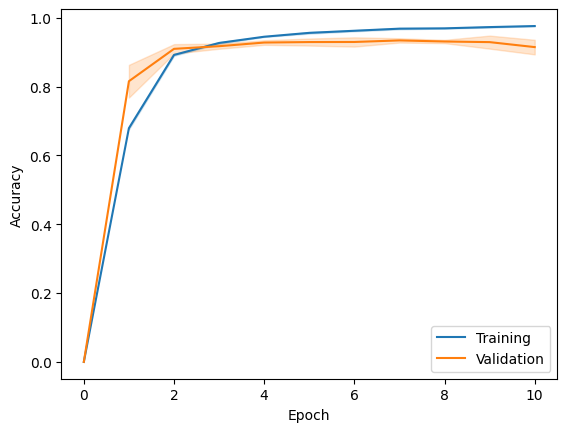

In [16]:
plt.figure()

df = pd.DataFrame(fold_history[0].history)

# Iterate through each dictionary and append to DataFrame
for i, history in enumerate(fold_history[1:]):
    df = pd.concat([df, pd.DataFrame(history.history)])

# Assuming df is your DataFrame with 'loss', 'accuracy', 'val_loss', 'val_accuracy'
# Reshape DataFrame to long format
df_long = df.reset_index().melt(id_vars='index', value_vars=['accuracy', 'val_accuracy'])
df_long.rename(columns={'index': 'Epoch', 'variable': 'Metric', 'value': 'Value'}, inplace=True)

df_long.loc[len(df_long)] = [-1, 'accuracy', 0]
df_long.loc[len(df_long)] = [-1, 'val_accuracy', 0]

df_long = df_long.replace({'val_accuracy': 'Validation', 'accuracy': 'Training'})



# Add 1 to all epoch values
df_long['Epoch'] = df_long['Epoch'] + 1

# Plotting
sns.lineplot(data=df_long, x='Epoch', y='Value', hue='Metric', ci='sd')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')

# Show the plot
plt.show()

The best tuned model is the cnn_model

In [17]:
cnn_model = best_model

In [5]:
cnn_model: Sequential = load_model('best_cnn_model.keras')

In [6]:
feature_output = cnn_model.layers[-4].output 
feature_model = Model(inputs=cnn_model.input, outputs=feature_output)

train_features = feature_model.predict(IMG_train)
test_features = feature_model.predict(IMG_test)

464/464 [==============================] - 3s 6ms/step


In [7]:
print(train_features.shape)

(59308, 576)


In [8]:
# Convert from one-hot encoding to integer encoding
LBL_train_int = np.argmax(LBL_train, axis=1)
LBL_test_int = np.argmax(LBL_test, axis=1)

In [9]:
# Convert from integer encoding back to original labels
LBL_train_original = label_encoder.inverse_transform(LBL_train_int)
LBL_test_original = label_encoder.inverse_transform(LBL_test_int)

In [22]:
logistic_regressor = LogisticRegression(solver='saga', max_iter=100, verbose=1, n_jobs=-1)
logistic_regressor.fit(train_features, LBL_train_original)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.11683507
Epoch 3, change: 0.08498301
Epoch 4, change: 0.05204967
Epoch 5, change: 0.03826317
Epoch 6, change: 0.03496558
Epoch 7, change: 0.03128616
Epoch 8, change: 0.03194483
Epoch 9, change: 0.02755932
Epoch 10, change: 0.02476282
Epoch 11, change: 0.02265844
Epoch 12, change: 0.02110585
Epoch 13, change: 0.01845838
Epoch 14, change: 0.01870201
Epoch 15, change: 0.01674079
Epoch 16, change: 0.01587442
Epoch 17, change: 0.01562573
Epoch 18, change: 0.01539968
Epoch 19, change: 0.01521565
Epoch 20, change: 0.01525611
Epoch 21, change: 0.01307954
Epoch 22, change: 0.01040746
Epoch 23, change: 0.01027605
Epoch 24, change: 0.01020248
Epoch 25, change: 0.00981763
Epoch 26, change: 0.00971660
Epoch 27, change: 0.00962003
Epoch 28, change: 0.00953173
Epoch 29, change: 0.00970850
Epoch 30, change: 0.00955185
Epoch 31, change: 0.00926345
Epoch 32, change: 0.00920611
Epoch 33, change: 0.00902283
Epoch 34, change: 0.00911976
Epoch 35, change: 0.009

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(n_jobs=-1, solver='saga', verbose=1)

In [25]:
predictions = logistic_regressor.predict(test_features)

In [26]:
report = classification_report(LBL_test_original, predictions)
print(report)

              precision    recall  f1-score   support

           一       0.99      0.99      0.99       129
           七       0.96      0.98      0.97       137
           上       0.96      0.97      0.96       169
           下       0.96      0.98      0.97       131
           不       0.97      0.95      0.96       146
           东       0.92      0.91      0.92       140
           么       0.96      0.96      0.96       136
           书       0.97      0.98      0.98       165
           买       0.97      0.96      0.97       146
           五       0.95      1.00      0.97       162
           京       0.94      0.94      0.94       145
           人       0.98      0.97      0.98       167
           他       0.95      0.97      0.96       130
           们       0.97      0.99      0.98       147
           会       0.98      0.95      0.96       150
           住       0.96      0.94      0.95       125
           作       0.96      0.95      0.95       136
           你       0.94    

In [10]:
# Define the KNN model
knn = KNeighborsClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_neighbors': [*range(1, 3, 2)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model with the grid search
grid_search.fit(train_features, LBL_train_original)



# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn

KeyboardInterrupt: 

In [ ]:
# Define the KNN model with the best parameters
knn_model = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'],
                                 weights=grid_search.best_params_['weights'],
                                 metric=grid_search.best_params_['metric'],
                                 p=grid_search.best_params_['p'])

# Fit the model with the training features and labels
knn_model.fit(train_features, LBL_train_original)

In [11]:
# Create an instance of the KNN classifier
knn = KNeighborsClassifier(n_neighbors=7, metric="euclidean")

# Fit the classifier to the training data
knn.fit(train_features, LBL_train_original)

KNeighborsClassifier(metric='euclidean', n_neighbors=7)

In [12]:
# Predict the labels for the test data
knn_predictions = knn.predict(test_features)

In [13]:
report = classification_report(LBL_test_original, knn_predictions)
print(report)

              precision    recall  f1-score   support

           一       0.98      0.99      0.99       129
           七       0.75      0.88      0.81       137
           上       0.92      0.89      0.91       169
           下       0.85      0.92      0.89       131
           不       0.84      0.77      0.81       146
           东       0.41      0.61      0.49       140
           么       0.66      0.90      0.76       136
           书       0.69      0.73      0.71       165
           买       0.64      0.70      0.67       146
           五       0.80      0.75      0.77       162
           京       0.59      0.48      0.53       145
           人       0.84      0.97      0.90       167
           他       0.55      0.72      0.62       130
           们       0.87      0.90      0.89       147
           会       0.70      0.72      0.71       150
           住       0.53      0.63      0.57       125
           作       0.55      0.70      0.61       136
           你       0.68    

In [14]:
def numpy_to_image(numpy_array):
    return Image.fromarray(numpy_array.astype('uint8'))

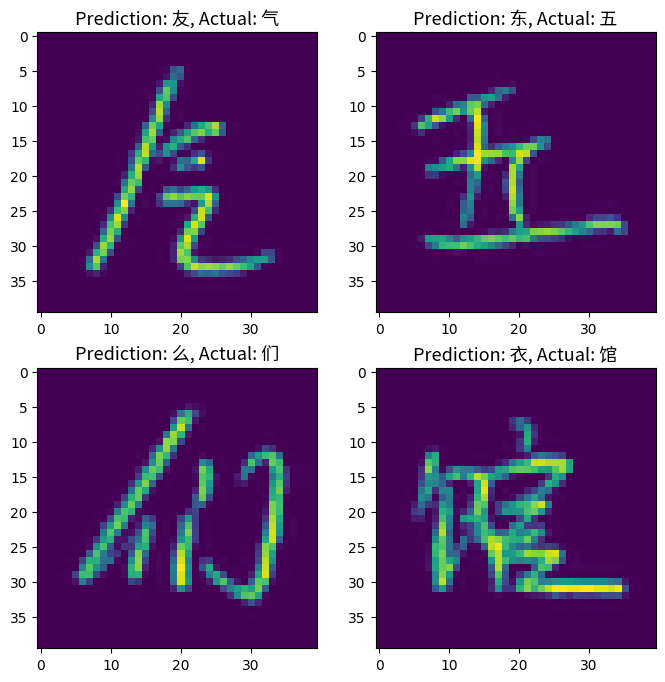

In [21]:
import random

# Get the indices of correct and wrong predictions
correct_indices = np.where(knn_predictions == LBL_test_original)[0]
wrong_indices = np.where(knn_predictions != LBL_test_original)[0]

correct_indices = random.sample(list(correct_indices), 4)
wrong_indices = random.sample(list(wrong_indices), 4)

correct_images = [IMG_test[idx] for idx in correct_indices]
wrong_images = [IMG_test[idx] for idx in wrong_indices]

correct_pred = (correct_indices, correct_images)
wrong_pred = (wrong_indices, wrong_images)

# Set the font for the plot
import matplotlib.font_manager as fm
font_path = 'NotoSansCJKsc-Regular.otf'
prop = fm.FontProperties(fname=font_path)

for idxs, images in (wrong_pred, ):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i in range(2):
        for j in range(2):
            idx = idxs[2 * i + j]
            numpy_image = images[2 * i + j] * 255
            img = numpy_to_image(numpy_image)
            axs[i][j].imshow(img)
            axs[i][j].set_title(f"Prediction: {knn_predictions[idx]}, Actual: {LBL_test_original[idx]}",
                                fontproperties=prop,
                                fontsize = 13)


In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0.15, 0.3, 0.5]
}

# Create an instance of the SGDClassifier
sgd_clf = SGDClassifier(max_iter=10, tol=1e-3, random_state=42, verbose=2, n_jobs=-1)

# Create a GridSearchCV object
grid_search = GridSearchCV(sgd_clf, param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model with the training data
grid_search.fit(train_features, LBL_train_original)

# Make predictions on the test data
y_pred = grid_search.predict(test_features)

# Evaluate the model
accuracy = accuracy_score(LBL_test_original, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 36.84, NNZs: 51, Bias: -0.794099, T: 29654, Avg. loss: 0.030460
Total training time: 0.18 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 32.54, NNZs: 11, Bias: -1.414694, T: 29654, Avg. loss: 0.031292
Total training time: 0.18 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 37.53, NNZs: 37, Bias: -0.935070, T: 59308, Avg. loss: 0.021151
Total training time: 0.36 seconds.
-- Epoch 3
Norm: 40.23, NNZs: 45, Bias: -2.197113, T: 29654, Avg. loss: 0.031938Norm: 39.34, NNZs: 49, Bias: -1.767253, T: 29654, Avg. loss: 0.028848-- Epoch 1
-- Epoch 1
Norm: 8.82, NNZs: 576, Bias: -1.668740, T: 29654, Avg. loss: 0.032377
Total training time: 0.18 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
Norm: 41.69, NNZs: 65, Bias: -0.399268, T: 29654, Avg. loss: 0.023836
Total training time: 0.40 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1

Total traini

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
Norm: 8.42, NNZs: 573, Bias: -0.271595, T: 29654, Avg. loss: 0.004467
Total training time: 0.22 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 11.30, NNZs: 575, Bias: -1.677661, T: 29654, Avg. loss: 0.021536
Total training time: 0.22 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 9.33, NNZs: 574, Bias: -1.503206, T: 29654, Avg. loss: 0.032833Norm: 7.23, NNZs: 572, Bias: -2.018760, T: 29654, Avg. loss: 0.035996
Total training time: 0.22 seconds.
-- Epoch 2
Norm: 6.79, NNZs: 573, Bias: -2.172491, T: 29654, Avg. loss: 0.034619-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 9.27, NNZs: 573, Bias: -1.894255, T: 29654, Avg. loss: 0.032364Norm: 10.72, NNZs: 576, Bias: -0.959218, T: 29654, Avg. loss: 0.022852
Total training time: 0.18 seconds.
-- Epoch 2
-- Epoch 1-- Epoch 1

Norm: 34.41, NNZs: 24, Bias: -1.048805, T: 29654, Avg. loss: 0.030747Norm: 37.97, NNZs: 17, Bias: -1.565850, T: 29654, Avg. loss: 0.033154
Total training time: 0.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.



Total training time: 0.60 seconds.
-- Epoch 3
-- Epoch 1

Total training time: 0.40 seconds.
-- Epoch 2
Norm: 7.38, NNZs: 576, Bias: -1.560990, T: 59308, Avg. loss: 0.020054
Total training time: 0.65 seconds.
-- Epoch 3
-- Epoch 1
Norm: 5.68, NNZs: 573, Bias: -1.478018, T: 59308, Avg. loss: 0.020928
Total training time: 0.58 seconds.
-- Epoch 3
-- Epoch 1
Norm: 10.50, NNZs: 575, Bias: -1.408375, T: 59308, Avg. loss: 0.012338
Total training time: 0.66 seconds.
-- Epoch 3
-- Epoch 1
Norm: 9.33, NNZs: 574, Bias: -1.503206, T: 29654, Avg. loss: 0.032833
Total training time: 0.28 seconds.
-- Epoch 2
-- Epoch 1
Norm: 11.14, NNZs: 575, Bias: -1.654603, T: 29654, Avg. loss: 0.022023Norm: 10.58, NNZs: 574, Bias: -0.640176, T: 29654, Avg. loss: 0.024790
Total training time: 0.37 seconds.
-- Epoch 2

Total training time: 0.68 seconds.
-- Epoch 3
-- Epoch 1

Total training time: 0.72 seconds.
-- Epoch 3
-- Epoch 1
Norm: 5.96, NNZs: 574, Bias: -1.799563, T: 59308, Avg. loss: 0.021128Norm: 9.34, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 7.42, NNZs: 576, Bias: -0.976690, T: 59308, Avg. loss: 0.019851
Total training time: 0.84 seconds.
-- Epoch 3
Norm: 40.19, NNZs: 29, Bias: -1.766182, T: 29654, Avg. loss: 0.032627-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 7.41, NNZs: 571, Bias: -2.029051, T: 29654, Avg. loss: 0.038011
Total training time: 0.72 seconds.
-- Epoch 2
Total training time: 1.11 seconds.
-- Epoch 4
Norm: 6.62, NNZs: 571, Bias: -1.650266, T: 29654, Avg. loss: 0.041556
Total training time: 0.76 seconds.
-- Epoch 2
Norm: 6.81, NNZs: 574, Bias: -1.850830, T: 59308, Avg. loss: 0.020569
Total training time: 1.08 seconds.
-- Epoch 3

Total training time: 1.22 seconds.
-- Epoch 2
Norm: 9.58, NNZs: 576, Bias: -1.111713, T: 88962, Avg. loss: 0.012460
Total training time: 1.15 seconds.
-- Epoch 4
Norm: 34.41, NNZs: 24, Bias: -1.048805, T: 29654, Avg. loss: 0.030747
Total training time: 1.29 seconds.
-- Epoch 2
Norm: 5.70, NNZs: 573, Bias: -1.294487, T: 59308, Avg. loss: 0.022776
Total training time: 1.09 se

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 7.38, NNZs: 575, Bias: -1.365319, T: 118616, Avg. loss: 0.017452
Total training time: 1.86 seconds.
-- Epoch 5
-- Epoch 1
Norm: 10.39, NNZs: 157, Bias: -1.673831, T: 29654, Avg. loss: 0.035743
Total training time: 1.89 seconds.
-- Epoch 2
-- Epoch 1

Total training time: 1.92 seconds.
-- Epoch 2
Norm: 8.01, NNZs: 574, Bias: -1.641796, T: 59308, Avg. loss: 0.019336
Total training time: 1.03 seconds.
-- Epoch 3
-- Epoch 1
Norm: 6.49, NNZs: 571, Bias: -1.499489, T: 59308, Avg. loss: 0.021113
Total training time: 1.49 seconds.
-- Epoch 3
-- Epoch 1
Norm: 10.78, NNZs: 187, Bias: -1.965375, T: 29654, Avg. loss: 0.033296
Total training time: 1.90 seconds.
-- Epoch 2
-- Epoch 1

Total training time: 1.10 seconds.
-- Epoch 3
-- Epoch 1
-- Epoch 1
Norm: 9.91, NNZs: 576, Bias: -1.326893, T: 59308, Avg. loss: 0.013068
Total training time: 1.57 seconds.
-- Epoch 3
Norm: 10.14, NNZs: 575, Bias: -1.256828, T: 88962, Avg. loss: 0.012351
Total training time: 1.56 seconds.
-- Epoch 4
-- Epoch 1
No

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s


Norm: 7.59, NNZs: 575, Bias: -0.247941, T: 207578, Avg. loss: 0.001532Norm: 4.08, NNZs: 575, Bias: -1.046927, T: 148270, Avg. loss: 0.021124
Total training time: 3.41 seconds.
-- Epoch 6
Norm: 5.16, NNZs: 574, Bias: -1.369084, T: 177924, Avg. loss: 0.018932
Total training time: 4.27 seconds.
-- Epoch 3
Norm: 5.99, NNZs: 576, Bias: -1.089798, T: 177924, Avg. loss: 0.018528
Total training time: 3.41 seconds.
-- Epoch 7
Norm: 34.94, NNZs: 18, Bias: -1.213664, T: 88962, Avg. loss: 0.020612
Total training time: 4.66 seconds.
-- Epoch 4

Total training time: 4.11 seconds.
Convergence after 7 epochs took 4.11 seconds
Norm: 7.06, NNZs: 261, Bias: -1.405153, T: 59308, Avg. loss: 0.020985
Total training time: 4.23 seconds.
-- Epoch 3
Norm: 4.44, NNZs: 574, Bias: -1.132335, T: 177924, Avg. loss: 0.018875
Total training time: 4.17 seconds.
-- Epoch 7
Norm: 38.27, NNZs: 38, Bias: -1.227619, T: 59308, Avg. loss: 0.021491
Total training time: 4.35 seconds.
-- Epoch 3
Norm: 38.61, NNZs: 13, Bias: -1.2

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s



Total training time: 4.31 seconds.
Total training time: 2.14 seconds.
-- Epoch 2

-- Epoch 3

Total training time: 2.07 seconds.
-- Epoch 2
Norm: 44.05, NNZs: 68, Bias: -1.149947, T: 88962, Avg. loss: 0.015318Norm: 9.11, NNZs: 575, Bias: -1.106274, T: 207578, Avg. loss: 0.011958
Total training time: 4.60 seconds.
Convergence after 7 epochs took 4.60 seconds
Norm: 4.90, NNZs: 573, Bias: -1.217963, T: 237232, Avg. loss: 0.018934
Total training time: 4.86 seconds.
Convergence after 8 epochs took 4.86 seconds
Norm: 42.58, NNZs: 60, Bias: -1.067926, T: 59308, Avg. loss: 0.013778Norm: 37.43, NNZs: 18, Bias: -1.290699, T: 59308, Avg. loss: 0.022723
Total training time: 3.06 seconds.
-- Epoch 6


Total training time: 3.91 seconds.
Convergence after 7 epochs took 3.91 seconds
-- Epoch 8
Norm: 6.78, NNZs: 569, Bias: -1.528619, T: 29654, Avg. loss: 0.038332
Total training time: 0.60 seconds.
-- Epoch 2
Norm: 6.24, NNZs: 574, Bias: -1.228341, T: 237232, Avg. loss: 0.017848
Total training time: 4.

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s




Total training time: 4.62 seconds.
-- Epoch 3
Total training time: 4.93 seconds.
Convergence after 7 epochs took 4.93 seconds
Norm: 41.26, NNZs: 34, Bias: -1.456658, T: 88962, Avg. loss: 0.020133
Total training time: 5.52 seconds.
Norm: 3.81, NNZs: 573, Bias: -1.184974, T: 177924, Avg. loss: 0.020507-- Epoch 4
Total training time: 3.45 seconds.
-- Epoch 7

Norm: 12.52, NNZs: 258, Bias: -1.065028, T: 59308, Avg. loss: 0.013854
Total training time: 4.74 seconds.
-- Epoch 3
Norm: 3.15, NNZs: 573, Bias: -1.115428, T: 237232, Avg. loss: 0.020497
Total training time: 4.98 seconds.
Convergence after 8 epochs took 4.98 seconds
-- Epoch 1
Norm: 9.79, NNZs: 576, Bias: -1.235153, T: 177924, Avg. loss: 0.011682
Total training time: 4.90 seconds.
Convergence after 8 epochs took 4.90 seconds
Norm: 10.62, NNZs: 223, Bias: 0.130416, T: 59308, Avg. loss: 0.002249
Total training time: 4.79 seconds.
-- Epoch 3
-- Epoch 1
Norm: 8.28, NNZs: 574, Bias: -1.653916, T: 29654, Avg. loss: 0.034863
Total traini

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s


Norm: 37.76, NNZs: 17, Bias: -1.388104, T: 59308, Avg. loss: 0.021302Norm: 5.18, NNZs: 576, Bias: -1.273115, T: 177924, Avg. loss: 0.018982
Total training time: 3.57 seconds.
-- Epoch 7
Norm: 43.53, NNZs: 56, Bias: -0.898319, T: 88962, Avg. loss: 0.015328Norm: 7.40, NNZs: 569, Bias: -2.437902, T: 29654, Avg. loss: 0.039298
Total training time: 0.66 seconds.
-- Epoch 2

Total training time: 5.65 seconds.
-- Epoch 4
-- Epoch 1
Norm: 4.40, NNZs: 574, Bias: -1.348142, T: 237232, Avg. loss: 0.018842
Total training time: 5.09 seconds.
Convergence after 8 epochs took 5.09 seconds
Norm: 38.01, NNZs: 15, Bias: -1.207742, T: 88962, Avg. loss: 0.020879-- Epoch 1

Total training time: 5.63 seconds.
-- Epoch 4

Total training time: 5.42 seconds.
Convergence after 8 epochs took 5.42 seconds
-- Epoch 1

Total training time: 5.57 seconds.
-- Epoch 4
Norm: 6.92, NNZs: 571, Bias: -1.791139, T: 29654, Avg. loss: 0.036633
Total training time: 0.67 seconds.
-- Epoch 2
Norm: 6.91, NNZs: 575, Bias: -1.216118

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.6s


-- Epoch 1
Norm: 3.53, NNZs: 574, Bias: -1.083159, T: 237232, Avg. loss: 0.020382
Total training time: 4.66 seconds.
Convergence after 8 epochs took 4.66 seconds
-- Epoch 1Norm: 4.88, NNZs: 575, Bias: -1.198758, T: 148270, Avg. loss: 0.020056

Total training time: 0.74 seconds.
-- Epoch 2
Total training time: 1.85 seconds.
-- Epoch 4
Norm: 5.94, NNZs: 575, Bias: -1.195853, T: 88962, Avg. loss: 0.020122
Total training time: 1.91 seconds.
-- Epoch 4
Norm: 6.36, NNZs: 575, Bias: -0.978081, T: 88962, Avg. loss: 0.019423Norm: 4.71, NNZs: 574, Bias: -1.096784, T: 118616, Avg. loss: 0.020489

Total training time: 1.86 seconds.
-- Epoch 4
Total training time: 2.49 seconds.
-- Epoch 5
Norm: 5.76, NNZs: 574, Bias: -1.413997, T: 59308, Avg. loss: 0.021923
Total training time: 1.12 seconds.
-- Epoch 3
Norm: 7.29, NNZs: 573, Bias: -1.493538, T: 29654, Avg. loss: 0.039268Norm: 6.37, NNZs: 575, Bias: -1.281156, T: 88962, Avg. loss: 0.019284
Total training time: 1.84 seconds.
-- Epoch 4

Total trainin

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.4s


Norm: 5.66, NNZs: 233, Bias: -1.196378, T: 148270, Avg. loss: 0.019658
Total training time: 12.35 seconds.
-- Epoch 6
Norm: 5.45, NNZs: 572, Bias: -1.231476, T: 177924, Avg. loss: 0.018624
Total training time: 4.05 seconds.
-- Epoch 7
Norm: 4.17, NNZs: 575, Bias: -1.218725, T: 177924, Avg. loss: 0.020338Norm: 5.25, NNZs: 574, Bias: -1.228219, T: 148270, Avg. loss: 0.019371
Total training time: 2.76 seconds.
-- Epoch 6

Total training time: 10.60 seconds.
-- Epoch 6
Norm: 5.19, NNZs: 575, Bias: -1.228664, T: 177924, Avg. loss: 0.019051Norm: 5.19, NNZs: 575, Bias: -1.228664, T: 177924, Avg. loss: 0.019051Norm: 4.13, NNZs: 573, Bias: -1.241455, T: 148270, Avg. loss: 0.020273
Total training time: 2.86 seconds.
-- Epoch 6
Norm: 4.92, NNZs: 576, Bias: -1.407562, T: 118616, Avg. loss: 0.019975
Total training time: 2.43 seconds.
-- Epoch 5

Total training time: 3.69 seconds.
-- Epoch 7
Norm: 5.45, NNZs: 572, Bias: -1.231476, T: 177924, Avg. loss: 0.018624
Total training time: 3.54 seconds.
-- 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.1s


Norm: 4.97, NNZs: 576, Bias: -1.239212, T: 148270, Avg. loss: 0.019406
Total training time: 3.73 seconds.
-- Epoch 7

Total training time: 11.09 seconds.Norm: 5.69, NNZs: 573, Bias: -1.027679, T: 207578, Avg. loss: 0.016848
Total training time: 4.27 seconds.
-- Epoch 8

-- Epoch 6
Norm: 4.66, NNZs: 576, Bias: -1.338336, T: 148270, Avg. loss: 0.019685
Total training time: 3.02 seconds.
-- Epoch 6

Total training time: 3.13 seconds.
-- Epoch 6

Total training time: 0.72 seconds.
-- Epoch 2
Norm: 41.11, NNZs: 16, Bias: -1.065574, T: 207578, Avg. loss: 0.020895
Total training time: 14.00 seconds.
-- Epoch 8

Total training time: 3.65 seconds.
-- Epoch 7
Norm: 4.40, NNZs: 573, Bias: -1.467413, T: 118616, Avg. loss: 0.020518
Total training time: 2.47 seconds.
-- Epoch 5


Total training time: 4.24 seconds.
-- Epoch 7
Total training time: 13.19 seconds.
-- Epoch 7
Norm: 7.58, NNZs: 178, Bias: -1.214482, T: 177924, Avg. loss: 0.018792
Total training time: 13.64 seconds.
-- Epoch 7
Norm: 4.19, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.3s


Norm: 4.87, NNZs: 575, Bias: -1.188735, T: 237232, Avg. loss: 0.019116Norm: 38.48, NNZs: 11, Bias: -1.033194, T: 237232, Avg. loss: 0.021164Norm: 9.02, NNZs: 576, Bias: -1.229435, T: 59308, Avg. loss: 0.015972Norm: 3.90, NNZs: 574, Bias: -1.115629, T: 177924, Avg. loss: 0.019988
Total training time: 15.28 seconds.
Convergence after 8 epochs took 15.28 seconds
-- Epoch 1Norm: 3.92, NNZs: 573, Bias: -1.250994, T: 177924, Avg. loss: 0.020083
Total training time: 3.73 seconds.
-- Epoch 7
Norm: 6.96, NNZs: 572, Bias: -1.966092, T: 29654, Avg. loss: 0.035283Norm: 6.52, NNZs: 569, Bias: -1.994167, T: 29654, Avg. loss: 0.045731
Total training time: 0.65 seconds.
-- Epoch 2
Norm: 8.80, NNZs: 200, Bias: -1.094233, T: 207578, Avg. loss: 0.016651
Total training time: 15.21 seconds.
Convergence after 7 epochs took 15.21 seconds
-- Epoch 1
Norm: 5.05, NNZs: 575, Bias: -1.103125, T: 237232, Avg. loss: 0.018968
Total training time: 5.51 seconds.
Convergence after 8 epochs took 5.51 seconds
Norm: 6.81,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.7s



-- Epoch 1

Total training time: 14.88 seconds.
Convergence after 7 epochs took 14.88 seconds

Total training time: 4.76 seconds.
-- Epoch 8
-- Epoch 1
Norm: 7.41, NNZs: 573, Bias: -1.548543, T: 29654, Avg. loss: 0.034322
Total training time: 0.57 seconds.
-- Epoch 2
Norm: 4.05, NNZs: 574, Bias: -1.205617, T: 207578, Avg. loss: 0.019332
Total training time: 4.43 seconds.
-- Epoch 8
Norm: 5.73, NNZs: 126, Bias: -1.187193, T: 207578, Avg. loss: 0.019841
Total training time: 15.52 seconds.
Convergence after 7 epochs took 15.52 seconds
-- Epoch 1
Norm: 3.74, NNZs: 574, Bias: -1.168110, T: 207578, Avg. loss: 0.019963
Total training time: 4.53 seconds.
-- Epoch 8

Total training time: 4.37 seconds.
-- Epoch 8
Norm: 8.64, NNZs: 573, Bias: -2.230308, T: 29654, Avg. loss: 0.033087
Total training time: 0.71 seconds.
-- Epoch 2
Norm: 4.25, NNZs: 574, Bias: -1.251986, T: 207578, Avg. loss: 0.019624
Total training time: 4.52 seconds.
-- Epoch 8
Norm: 10.51, NNZs: 237, Bias: -1.206721, T: 207578, A

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.9s



Norm: 4.72, NNZs: 225, Bias: -1.146395, T: 207578, Avg. loss: 0.020462
Total training time: 16.30 seconds.
-- Epoch 8
Norm: 5.55, NNZs: 573, Bias: -1.234574, T: 88962, Avg. loss: 0.020239
Total training time: 1.70 seconds.
-- Epoch 4
Norm: 37.04, NNZs: 19, Bias: -1.189704, T: 59308, Avg. loss: 0.022258
Total training time: 4.46 seconds.
-- Epoch 3

Total training time: 16.39 seconds.
Convergence after 7 epochs took 16.39 seconds
-- Epoch 1


Total training time: 1.99 seconds.
-- Epoch 4
Total training time: 16.10 seconds.
Convergence after 7 epochs took 16.10 seconds
-- Epoch 1
Norm: 9.02, NNZs: 576, Bias: -1.229435, T: 59308, Avg. loss: 0.015972
Total training time: 1.31 seconds.
-- Epoch 3

Total training time: 0.64 seconds.
-- Epoch 2

Total training time: 15.58 seconds.
Convergence after 7 epochs took 15.58 seconds
-- Epoch 1

Total training time: 1.37 seconds.
-- Epoch 3
Norm: 7.09, NNZs: 574, Bias: -1.437742, T: 59308, Avg. loss: 0.020913
Total training time: 1.25 seconds.
-- Ep

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.9s


Norm: 8.76, NNZs: 576, Bias: -1.512964, T: 118616, Avg. loss: 0.015063Norm: 37.50, NNZs: 35, Bias: -1.141844, T: 59308, Avg. loss: 0.021547Norm: 45.10, NNZs: 55, Bias: -1.188887, T: 207578, Avg. loss: 0.015288
Total training time: 14.95 seconds.
Convergence after 7 epochs took 14.95 seconds

Total training time: 4.36 seconds.
-- Epoch 3
-- Epoch 1


Total training time: 3.15 seconds.
-- Epoch 6

Total training time: 2.06 seconds.
-- Epoch 4
Norm: 7.09, NNZs: 574, Bias: -1.131142, T: 88962, Avg. loss: 0.018282Norm: 8.95, NNZs: 576, Bias: -1.669913, T: 118616, Avg. loss: 0.014666Norm: 4.77, NNZs: 573, Bias: -1.013823, T: 177924, Avg. loss: 0.019864
Total training time: 3.76 seconds.
-- Epoch 7

Total training time: 2.84 seconds.
-- Epoch 5
Norm: 40.56, NNZs: 41, Bias: -1.635744, T: 29654, Avg. loss: 0.032512
Total training time: 2.23 seconds.
-- Epoch 2
Norm: 5.47, NNZs: 573, Bias: -1.266237, T: 88962, Avg. loss: 0.020261
Total training time: 2.07 seconds.
-- Epoch 4
Norm: 41.54, NNZs: 2

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.4s


Norm: 5.08, NNZs: 575, Bias: -1.118377, T: 148270, Avg. loss: 0.018965Norm: 4.79, NNZs: 574, Bias: -1.116582, T: 207578, Avg. loss: 0.019557
Total training time: 4.01 seconds.
-- Epoch 8
Norm: 7.78, NNZs: 576, Bias: -1.113444, T: 207578, Avg. loss: 0.015233
Total training time: 4.36 seconds.
Convergence after 7 epochs took 4.36 seconds

Total training time: 2.40 seconds.
-- Epoch 2
Norm: 8.16, NNZs: 147, Bias: -1.138210, T: 59308, Avg. loss: 0.022075Norm: 7.33, NNZs: 563, Bias: -1.825887, T: 29654, Avg. loss: 0.038602Norm: 4.98, NNZs: 574, Bias: -1.121788, T: 207578, Avg. loss: 0.019080
Total training time: 4.43 seconds.
-- Epoch 8

Total training time: 4.57 seconds.
-- Epoch 8


Total training time: 4.02 seconds.
-- Epoch 7
Total training time: 4.00 seconds.
-- Epoch 7

Norm: 9.70, NNZs: 316, Bias: -0.973539, T: 29654, Avg. loss: 0.031555
Total training time: 2.56 seconds.
-- Epoch 2
Norm: 3.97, NNZs: 206, Bias: -1.053798, T: 237232, Avg. loss: 0.020978Norm: 4.50, NNZs: 574, Bias: -1.

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.6s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.7s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.7s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.2s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.4s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.



Norm: 41.71, NNZs: 33, Bias: -1.216165, T: 59308, Avg. loss: 0.021896
Total training time: 3.54 seconds.
-- Epoch 3
Norm: 5.59, NNZs: 573, Bias: -1.255777, T: 148270, Avg. loss: 0.019406
Total training time: 3.45 seconds.
-- Epoch 6

Total training time: 1.77 seconds.
-- Epoch 2
-- Epoch 1
Norm: 37.08, NNZs: 37, Bias: -2.171909, T: 29654, Avg. loss: 0.032560
Total training time: 1.79 seconds.
-- Epoch 2
Norm: 4.09, NNZs: 574, Bias: -1.189291, T: 237232, Avg. loss: 0.019358
Total training time: 4.91 seconds.
Convergence after 8 epochs took 4.91 seconds
Norm: 37.13, NNZs: 19, Bias: -1.576489, T: 29654, Avg. loss: 0.033374
Total training time: 2.39 seconds.
-- Epoch 2
Norm: 39.37, NNZs: 24, Bias: -1.405273, T: 59308, Avg. loss: 0.021833
Total training time: 4.37 seconds.
-- Epoch 3
Norm: 38.74, NNZs: 14, Bias: -1.093192, T: 207578, Avg. loss: 0.020498
Total training time: 15.53 seconds.
Convergence after 7 epochs took 15.53 seconds
-- Epoch 1
Norm: 4.70, NNZs: 210, Bias: -1.162984, T: 20

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 39.67, NNZs: 18, Bias: -1.242964, T: 118616, Avg. loss: 0.020856Norm: 43.90, NNZs: 20, Bias: -1.162125, T: 177924, Avg. loss: 0.020436Norm: 38.69, NNZs: 10, Bias: -1.093824, T: 177924, Avg. loss: 0.020731Norm: 34.96, NNZs: 14, Bias: -1.169095, T: 118616, Avg. loss: 0.020561
Total training time: 7.34 seconds.
-- Epoch 5

Total training time: 1.61 seconds.
-- Epoch 2
Norm: 37.52, NNZs: 15, Bias: -1.314084, T: 177924, Avg. loss: 0.020393
Total training time: 10.88 seconds.
-- Epoch 7
Norm: 7.44, NNZs: 151, Bias: -1.293899, T: 118616, Avg. loss: 0.019510Norm: 5.89, NNZs: 117, Bias: -1.142341, T: 148270, Avg. loss: 0.020438


Total training time: 11.07 seconds.Total training time: 7.00 seconds.

-- Epoch 7
-- Epoch 5
Total training time: 5.81 seconds.
-- Epoch 4
Norm: 6.46, NNZs: 120, Bias: -1.385601, T: 148270, Avg. loss: 0.019695Norm: 37.42, NNZs: 18, Bias: -1.155679, T: 148270, Avg. loss: 0.020287Norm: 39.68, NNZs: 20, Bias: -1.195056, T: 118616, Avg. loss: 0.020710
Total training 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 12.77, NNZs: 86, Bias: -1.377857, T: 29654, Avg. loss: 0.031372Norm: 5.99, NNZs: 234, Bias: -1.247537, T: 88962, Avg. loss: 0.020546
Total training time: 5.39 seconds.
-- Epoch 4
-- Epoch 1
Norm: 14.96, NNZs: 159, Bias: -0.016950, T: 29654, Avg. loss: 0.005687Norm: 15.80, NNZs: 145, Bias: -1.231522, T: 59308, Avg. loss: 0.014315
Total training time: 1.88 seconds.
-- Epoch 2

Total training time: 1.95 seconds.
-- Epoch 2
Norm: 14.21, NNZs: 111, Bias: -1.864893, T: 29654, Avg. loss: 0.032488Norm: 17.39, NNZs: 188, Bias: -1.155684, T: 29654, Avg. loss: 0.023030
Total training time: 2.54 seconds.
-- Epoch 2
Norm: 39.92, NNZs: 10, Bias: -1.072214, T: 207578, Avg. loss: 0.020848Norm: 14.36, NNZs: 101, Bias: -1.757397, T: 29654, Avg. loss: 0.034707
Total training time: 1.93 seconds.
-- Epoch 2
Norm: 13.25, NNZs: 53, Bias: -1.394362, T: 29654, Avg. loss: 0.032698
Total training time: 2.00 seconds.
-- Epoch 2


Total training time: 2.63 seconds.
-- Epoch 3
Total training time: 12.45 secon

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 6.25, NNZs: 110, Bias: -1.262404, T: 118616, Avg. loss: 0.020905-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 39.80, NNZs: 15, Bias: -1.053935, T: 207578, Avg. loss: 0.020489
Total training time: 12.96 seconds.
Convergence after 7 epochs took 12.96 seconds
-- Epoch 1

Total training time: 7.02 seconds.
-- Epoch 5
-- Epoch 1
Norm: 13.48, NNZs: 144, Bias: -0.028503, T: 59308, Avg. loss: 0.002428-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 40.19, NNZs: 10, Bias: -1.127594, T: 177924, Avg. loss: 0.020841
Total training time: 10.29 seconds.
-- Epoch 7
-- Epoch 1
Norm: 39.15, NNZs: 12, Bias: -1.169975, T: 148270, Avg. loss: 0.020218
Total training time: 7.86 seconds.
-- Epoch 6
Norm: 5.55, NNZs: 96, Bias: -1.245412, T: 148270, Avg. loss: 0.020849
Total training time: 8.50 seconds.
-- Epoch 6
-- Epoch 1
-

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s


Total training time: 5.12 seconds.
Convergence after 7 epochs took 5.12 seconds
Norm: 39.59, NNZs: 28, Bias: -1.635291, T: 29654, Avg. loss: 0.034571
Total training time: 2.38 seconds.
-- Epoch 2
-- Epoch 1
Norm: 4.98, NNZs: 104, Bias: -1.136898, T: 237232, Avg. loss: 0.020254Norm: 0.44, NNZs: 573, Bias: -1.014816, T: 207578, Avg. loss: 0.020467
Total training time: 5.14 seconds.
Convergence after 7 epochs took 5.14 seconds

Total training time: 15.60 seconds.
Convergence after 8 epochs took 15.60 seconds
-- Epoch 1
-- Epoch 1
Norm: 0.42, NNZs: 572, Bias: -1.007781, T: 177924, Avg. loss: 0.020221
Total training time: 4.62 seconds.
-- Epoch 7
Norm: 0.38, NNZs: 576, Bias: -1.005025, T: 207578, Avg. loss: 0.020777
Total training time: 5.11 seconds.
Convergence after 7 epochs took 5.11 seconds

Total training time: 2.38 seconds.
-- Epoch 2
Norm: 10.37, NNZs: 0, Bias: -1.000477, T: 88962, Avg. loss: 0.020030
Total training time: 5.91 seconds.
-- Epoch 4
-- Epoch 1
Norm: 0.77, NNZs: 573, Bia

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s



Total training time: 1.01 seconds.
-- Epoch 2
Norm: 44.74, NNZs: 54, Bias: -1.886650, T: 29654, Avg. loss: 0.032022
Total training time: 2.76 seconds.
-- Epoch 2
Norm: 0.70, NNZs: 571, Bias: -1.043459, T: 29654, Avg. loss: 0.023383
Total training time: 0.99 seconds.
-- Epoch 2
Norm: 5.26, NNZs: 238, Bias: -1.228147, T: 177924, Avg. loss: 0.019755
Total training time: 13.03 seconds.
-- Epoch 7
Norm: 0.97, NNZs: 576, Bias: -0.994764, T: 207578, Avg. loss: 0.018588
Total training time: 5.65 seconds.
Convergence after 7 epochs took 5.65 seconds
-- Epoch 1

-- Epoch 2
Norm: 5.10, NNZs: 214, Bias: -1.196734, T: 118616, Avg. loss: 0.020583
Total training time: 9.38 seconds.
-- Epoch 5
Norm: 11.47, NNZs: 0, Bias: -1.000102, T: 88962, Avg. loss: 0.020167
Total training time: 6.04 seconds.
-- Epoch 4
Norm: 10.48, NNZs: 105, Bias: -1.245273, T: 118616, Avg. loss: 0.019606
Total training time: 8.82 seconds.
-- Epoch 5
Norm: 37.89, NNZs: 23, Bias: -1.640805, T: 29654, Avg. loss: 0.034428Norm: 5.74

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.7s


Norm: 36.14, NNZs: 18, Bias: -1.250567, T: 118616, Avg. loss: 0.020830Norm: 7.72, NNZs: 129, Bias: -1.235735, T: 88962, Avg. loss: 0.020837
Total training time: 8.47 seconds.
-- Epoch 4

Total training time: 12.33 seconds.
-- Epoch 6
Norm: 9.55, NNZs: 113, Bias: -1.792507, T: 29654, Avg. loss: 0.032943Norm: 12.19, NNZs: 0, Bias: -1.000063, T: 207578, Avg. loss: 0.019542Norm: 40.33, NNZs: 12, Bias: -1.091420, T: 148270, Avg. loss: 0.020616
Total training time: 12.88 seconds.
-- Epoch 6

Total training time: 7.57 seconds.
-- Epoch 4
Norm: 12.72, NNZs: 148, Bias: -0.073500, T: 207578, Avg. loss: 0.002341Norm: 9.54, NNZs: 0, Bias: -1.000012, T: 207578, Avg. loss: 0.019407
Norm: 0.61, NNZs: 575, Bias: -1.035054, T: 118616, Avg. loss: 0.020008
Total training time: 3.03 seconds.
-- Epoch 5

Total training time: 2.98 seconds.
-- Epoch 2
Norm: 6.72, NNZs: 232, Bias: -1.259296, T: 59308, Avg. loss: 0.022200
Total training time: 6.25 seconds.
-- Epoch 3

Total training time: 2.43 seconds.
-- Epoc

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.5s



Total training time: 16.65 seconds.
-- Epoch 8
Norm: 0.50, NNZs: 576, Bias: -1.028230, T: 177924, Avg. loss: 0.019882
Total training time: 2.04 seconds.
-- Epoch 4


Total training time: 2.72 seconds.
-- Epoch 5
Total training time: 17.28 seconds.
Convergence after 7 epochs took 17.28 seconds
-- Epoch 1
-- Epoch 1
Norm: 0.42, NNZs: 575, Bias: -1.024835, T: 177924, Avg. loss: 0.020362Norm: 0.62, NNZs: 572, Bias: -1.042721, T: 88962, Avg. loss: 0.019881
Total training time: 2.28 seconds.
-- Epoch 4
Norm: 7.75, NNZs: 60, Bias: -1.062436, T: 207578, Avg. loss: 0.020195
Total training time: 17.31 seconds.
Convergence after 7 epochs took 17.31 seconds
-- Epoch 1
Total training time: 2.97 seconds.
-- Epoch 5
Norm: 8.84, NNZs: 148, Bias: -1.434615, T: 59308, Avg. loss: 0.021706
Total training time: 5.65 seconds.
-- Epoch 3


Total training time: 12.81 seconds.
-- Epoch 6

Total training time: 3.00 seconds.
-- Epoch 5

Total training time: 4.27 seconds.
-- Epoch 7
Norm: 10.53, NNZs: 172, Bias:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.6s



Total training time: 7.24 seconds.
-- Epoch 4

Total training time: 3.81 seconds.
-- Epoch 6

Total training time: 14.30 seconds.
Convergence after 7 epochs took 14.30 seconds
-- Epoch 1Norm: 7.62, NNZs: 44, Bias: -1.116651, T: 207578, Avg. loss: 0.020838
Total training time: 16.99 seconds.
Convergence after 7 epochs took 16.99 seconds

-- Epoch 1Norm: 10.52, NNZs: 0, Bias: -1.000011, T: 207578, Avg. loss: 0.020421
Total training time: 14.37 seconds.
Convergence after 7 epochs took 14.37 seconds
-- Epoch 1Norm: 0.57, NNZs: 576, Bias: -0.996180, T: 148270, Avg. loss: 0.019583
Total training time: 3.73 seconds.
-- Epoch 6
Norm: 7.14, NNZs: 119, Bias: -1.270640, T: 88962, Avg. loss: 0.020189
Total training time: 7.85 seconds.
-- Epoch 4
Norm: 9.24, NNZs: 300, Bias: -1.816526, T: 29654, Avg. loss: 0.038080Norm: 5.27, NNZs: 242, Bias: -1.232932, T: 237232, Avg. loss: 0.019488
Total training time: 3.81 seconds.
-- Epoch 6
Norm: 41.15, NNZs: 11, Bias: -1.089891, T: 177924, Avg. loss: 0.02099

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.7s


Total training time: 17.69 seconds.
Convergence after 7 epochs took 17.69 seconds
-- Epoch 1
Norm: 8.48, NNZs: 75, Bias: -1.043300, T: 207578, Avg. loss: 0.019959
Total training time: 11.95 seconds.
-- Epoch 6

Total training time: 12.45 seconds.
-- Epoch 6
Norm: 9.77, NNZs: 145, Bias: -1.626938, T: 29654, Avg. loss: 0.035774
Total training time: 2.57 seconds.
-- Epoch 2
Norm: 0.47, NNZs: 571, Bias: -1.020829, T: 118616, Avg. loss: 0.019596
Total training time: 3.03 seconds.
-- Epoch 5
Norm: 37.04, NNZs: 11, Bias: -1.012339, T: 148270, Avg. loss: 0.020264Norm: 36.24, NNZs: 16, Bias: -1.070212, T: 177924, Avg. loss: 0.020752Norm: 4.18, NNZs: 202, Bias: -1.193000, T: 207578, Avg. loss: 0.020162
Total training time: 18.23 seconds.
-- Epoch 8

Total training time: 7.29 seconds.
-- Epoch 4
Norm: 12.61, NNZs: 149, Bias: -1.049558, T: 207578, Avg. loss: 0.014907
Total training time: 18.31 seconds.
Convergence after 7 epochs took 18.31 seconds
Norm: 41.15, NNZs: 11, Bias: -1.089891, T: 177924,

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.6s finished


Norm: 33.92, NNZs: 11, Bias: -1.182263, T: 148270, Avg. loss: 0.019905Norm: 11.78, NNZs: 94, Bias: -1.446481, T: 59308, Avg. loss: 0.020829
Total training time: 5.44 seconds.
-- Epoch 3
Norm: 11.51, NNZs: 85, Bias: -1.497255, T: 59308, Avg. loss: 0.019632Total training time: 17.24 seconds.
Convergence after 7 epochs took 17.24 seconds
-- Epoch 1
Norm: 33.92, NNZs: 11, Bias: -1.182263, T: 148270, Avg. loss: 0.019905
Total training time: 16.91 seconds.
Convergence after 7 epochs took 16.91 seconds
-- Epoch 1
Norm: 11.80, NNZs: 0, Bias: -1.002000, T: 59308, Avg. loss: 0.020122
Total training time: 4.86 seconds.
-- Epoch 3
Norm: 0.47, NNZs: 573, Bias: -1.021469, T: 207578, Avg. loss: 0.019830
Total training time: 5.10 seconds.
Convergence after 7 epochs took 5.10 seconds
Norm: 38.28, NNZs: 21, Bias: -1.568852, T: 29654, Avg. loss: 0.035692Norm: 39.28, NNZs: 14, Bias: -1.097795, T: 207578, Avg. loss: 0.020439

Total training time: 15.29 seconds.
Norm: 35.70, NNZs: 13, Bias: -1.086514, T: 17

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.2s finished


Norm: 7.82, NNZs: 152, Bias: -1.323282, T: 88962, Avg. loss: 0.020024
Total training time: 9.21 seconds.
-- Epoch 4

Total training time: 5.62 seconds.
-- Epoch 3
Norm: 38.78, NNZs: 12, Bias: -1.209444, T: 148270, Avg. loss: 0.020549Norm: 41.87, NNZs: 20, Bias: -1.307825, T: 88962, Avg. loss: 0.020990Norm: 12.82, NNZs: 0, Bias: -1.000046, T: 118616, Avg. loss: 0.019925Norm: 10.36, NNZs: 72, Bias: -1.187560, T: 88962, Avg. loss: 0.020513
Total training time: 7.56 seconds.
-- Epoch 4
Norm: 38.26, NNZs: 7, Bias: -1.075968, T: 207578, Avg. loss: 0.020306
Total training time: 17.90 seconds.
Norm: 39.51, NNZs: 8, Bias: -1.041102, T: 207578, Avg. loss: 0.020653
Total training time: 18.11 seconds.
Convergence after 7 epochs took 18.11 seconds
-- Epoch 8
-- Epoch 1
Total training time: 12.15 seconds.
-- Epoch 6

Total training time: 8.65 seconds.
-- Epoch 5
Norm: 38.99, NNZs: 22, Bias: -1.781926, T: 29654, Avg. loss: 0.033181Norm: 42.40, NNZs: 12, Bias: -1.068966, T: 177924, Avg. loss: 0.019976

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 40.80, NNZs: 20, Bias: -1.445593, T: 59308, Avg. loss: 0.022170
Total training time: 4.17 seconds.
-- Epoch 3
Norm: 39.05, NNZs: 14, Bias: -1.419749, T: 59308, Avg. loss: 0.022921
Total training time: 4.51 seconds.
-- Epoch 3
Norm: 41.09, NNZs: 10, Bias: -1.242773, T: 88962, Avg. loss: 0.021503
Total training time: 6.93 seconds.
-- Epoch 4
-- Epoch 1
Norm: 37.34, NNZs: 23, Bias: -1.371227, T: 29654, Avg. loss: 0.034773
Total training time: 12.24 seconds.
-- Epoch 6
Norm: 37.20, NNZs: 12, Bias: -1.055323, T: 237232, Avg. loss: 0.020369
Total training time: 18.85 seconds.
Convergence after 8 epochs took 18.85 seconds
-- Epoch 1

Total training time: 4.50 seconds.
-- Epoch 3
Norm: 6.50, NNZs: 248, Bias: -1.304555, T: 88962, Avg. loss: 0.020348
Total training time: 7.96 seconds.
-- Epoch 4
Norm: 37.00, NNZs: 15, Bias: -1.170058, T: 88962, Avg. loss: 0.021109
Total training time: 6.72 seconds.
-- Epoch 4
Norm: 5.79, NNZs: 118, Bias: -1.141442, T: 177924, Avg. loss: 0.020133
Total trai

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.




Total training time: 4.23 seconds.
-- Epoch 3
Total training time: 7.00 seconds.
-- Epoch 4
Norm: 37.07, NNZs: 44, Bias: -1.458991, T: 59308, Avg. loss: 0.020318
Total training time: 4.26 seconds.
-- Epoch 3
Norm: 11.75, NNZs: 0, Bias: -1.000000, T: 207578, Avg. loss: 0.020015
Total training time: 4.26 seconds.
-- Epoch 3
Norm: 39.32, NNZs: 15, Bias: -1.141052, T: 118616, Avg. loss: 0.020826
Total training time: 8.95 seconds.
-- Epoch 5
Norm: 9.01, NNZs: 65, Bias: -1.291433, T: 148270, Avg. loss: 0.020449
Total training time: 12.68 seconds.
-- Epoch 6

Total training time: 17.22 seconds.
Convergence after 7 epochs took 17.22 seconds
-- Epoch 1
Norm: 5.82, NNZs: 126, Bias: -1.085674, T: 177924, Avg. loss: 0.020167
Total training time: 15.78 seconds.
-- Epoch 7
Norm: 6.13, NNZs: 236, Bias: -1.278965, T: 118616, Avg. loss: 0.018794Norm: 13.57, NNZs: 0, Bias: -1.000001, T: 207578, Avg. loss: 0.019677
Total training time: 14.32 seconds.
Convergence after 7 epochs took 14.32 seconds
Norm: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.9s


Norm: 11.16, NNZs: 0, Bias: -1.000318, T: 59308, Avg. loss: 0.020400Norm: 0.42, NNZs: 10, Bias: -1.001987, T: 207578, Avg. loss: 0.020273
Total training time: 14.79 seconds.
Convergence after 7 epochs took 14.79 seconds
-- Epoch 1
Total training time: 1.54 seconds.
-- Epoch 2
Norm: 5.19, NNZs: 88, Bias: -1.078791, T: 177924, Avg. loss: 0.020317
Total training time: 12.78 seconds.
-- Epoch 7
Norm: 8.36, NNZs: 71, Bias: -1.162803, T: 148270, Avg. loss: 0.019934
Total training time: 10.84 seconds.
-- Epoch 6
Norm: 38.34, NNZs: 12, Bias: -1.098267, T: 148270, Avg. loss: 0.020696
Total training time: 10.13 seconds.
-- Epoch 6
Norm: 5.63, NNZs: 229, Bias: -1.266341, T: 88962, Avg. loss: 0.020655Norm: 5.00, NNZs: 87, Bias: -1.066481, T: 177924, Avg. loss: 0.020386
Total training time: 13.24 seconds.
-- Epoch 7
Norm: 12.31, NNZs: 0, Bias: -1.001299, T: 29654, Avg. loss: 0.022131
Total training time: 1.44 seconds.
-- Epoch 2
Norm: 5.52, NNZs: 234, Bias: -1.154727, T: 118616, Avg. loss: 0.020496

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.9s



Total training time: 14.89 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 17, Bias: -1.007693, T: 207578, Avg. loss: 0.019923Total training time: 1.45 seconds.
-- Epoch 2

Total training time: 1.74 seconds.
-- Epoch 2
Norm: 39.42, NNZs: 11, Bias: -1.085733, T: 237232, Avg. loss: 0.020792
Total training time: 15.04 seconds.
Convergence after 7 epochs took 15.04 seconds
-- Epoch 1

Total training time: 6.53 seconds.
-- Epoch 4

Total training time: 15.44 seconds.
Convergence after 7 epochs took 15.44 seconds
Norm: 7.84, NNZs: 48, Bias: -1.083337, T: 177924, Avg. loss: 0.020920-- Epoch 1
Norm: 5.55, NNZs: 107, Bias: -1.107668, T: 177924, Avg. loss: 0.020738Norm: 5.67, NNZs: 219, Bias: -1.274356, T: 88962, Avg. loss: 0.021338
Total training time: 6.59 seconds.
-- Epoch 4
Norm: 12.23, NNZs: 117, Bias: -1.390185, T: 177924, Avg. loss: 0.016597
Total training time: 12.61 seconds.
-- Epoch 7
Norm: 4.65, NNZs: 90, Bias: -1.073961, T: 237232, Avg. loss: 0.019862Norm: 0.41, NNZs: 8, Bias: -1.004959, T: 2

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Norm: 9.08, NNZs: 0, Bias: -1.000932, T: 148270, Avg. loss: 0.019700
Total training time: 7.43 seconds.
-- Epoch 6
Norm: 42.25, NNZs: 15, Bias: -1.184505, T: 207578, Avg. loss: 0.020822
Total training time: 7.09 seconds.
-- Epoch 5
Norm: 6.91, NNZs: 32, Bias: -1.057670, T: 207578, Avg. loss: 0.019624
Total training time: 12.57 seconds.
Convergence after 7 epochs took 12.57 seconds
-- Epoch 1
Norm: 0.46, NNZs: 6, Bias: -1.006859, T: 148270, Avg. loss: 0.020576
Total training time: 8.35 seconds.
-- Epoch 7
Norm: 0.52, NNZs: 5, Bias: -1.010014, T: 118616, Avg. loss: 0.020324Norm: 5.04, NNZs: 225, Bias: -1.190932, T: 177924, Avg. loss: 0.019830
Total training time: 11.28 seconds.
-- Epoch 7
Norm: 39.04, NNZs: 12, Bias: -1.046010, T: 207578, Avg. loss: 0.020121
Total training time: 7.84 seconds.
-- Epoch 6
Norm: 0.52, NNZs: 6, Bias: -0.999258, T: 118616, Avg. loss: 0.019981
Total training time: 6.55 seconds.
-- Epoch 5

Total training time: 11.66 seconds.
Convergence after 7 epochs took 11.

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished



Total training time: 6.09 seconds.
-- Epoch 5
Norm: 0.53, NNZs: 8, Bias: -1.006550, T: 118616, Avg. loss: 0.020385Norm: 0.54, NNZs: 19, Bias: -1.009522, T: 118616, Avg. loss: 0.020435
Total training time: 5.93 seconds.
-- Epoch 5
Norm: 5.08, NNZs: 212, Bias: -1.169314, T: 118616, Avg. loss: 0.020542Norm: 13.53, NNZs: 76, Bias: -1.882620, T: 29654, Avg. loss: 0.034243
Total training time: 1.66 seconds.
-- Epoch 2
Norm: 4.14, NNZs: 202, Bias: -1.089630, T: 237232, Avg. loss: 0.020379
Total training time: 16.91 seconds.
Convergence after 8 epochs took 16.91 seconds
Norm: 0.54, NNZs: 6, Bias: -1.009335, T: 118616, Avg. loss: 0.019981
Total training time: 6.78 seconds.
-- Epoch 5

Total training time: 1.92 seconds.
-- Epoch 2
Norm: 0.52, NNZs: 3, Bias: -1.006907, T: 118616, Avg. loss: 0.020050
Total training time: 6.14 seconds.
-- Epoch 5
Norm: 3.53, NNZs: 186, Bias: -1.018396, T: 237232, Avg. loss: 0.020278
Total training time: 16.00 seconds.
Convergence after 8 epochs took 16.00 seconds


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Norm: 8.80, NNZs: 0, Bias: -1.007839, T: 88962, Avg. loss: 0.019420
Total training time: 8.15 seconds.
-- Epoch 7
Norm: 11.90, NNZs: 0, Bias: -1.000006, T: 177924, Avg. loss: 0.019889
Total training time: 8.47 seconds.
-- Epoch 7
Norm: 0.50, NNZs: 10, Bias: -0.995318, T: 118616, Avg. loss: 0.019899
Total training time: 6.19 seconds.
-- Epoch 5
Norm: 7.65, NNZs: 298, Bias: -1.488145, T: 177924, Avg. loss: 0.017332
Total training time: 4.46 seconds.
-- Epoch 4
Norm: 12.34, NNZs: 0, Bias: -1.001013, T: 177924, Avg. loss: 0.020160
Total training time: 8.30 seconds.
-- Epoch 7
Norm: 38.34, NNZs: 11, Bias: -1.135705, T: 177924, Avg. loss: 0.020967
Total training time: 12.11 seconds.
-- Epoch 7
Norm: 4.39, NNZs: 221, Bias: -1.134890, T: 237232, Avg. loss: 0.020122
Total training time: 16.13 seconds.
Convergence after 8 epochs took 16.13 seconds

Total training time: 9.52 seconds.
-- Epoch 7
Norm: 9.53, NNZs: 55, Bias: -1.281328, T: 88962, Avg. loss: 0.021293Norm: 12.04, NNZs: 0, Bias: -1.0000

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Norm: 12.14, NNZs: 0, Bias: -1.002548, T: 207578, Avg. loss: 0.019339
Total training time: 10.12 seconds.
Convergence after 7 epochs took 10.12 seconds
-- Epoch 1
Norm: 11.98, NNZs: 0, Bias: -1.000325, T: 29654, Avg. loss: 0.022518Norm: 10.27, NNZs: 0, Bias: -1.000082, T: 29654, Avg. loss: 0.021643
Total training time: 1.13 seconds.
-- Epoch 2
Norm: 0.44, NNZs: 4, Bias: -1.001739, T: 177924, Avg. loss: 0.020020Norm: 10.18, NNZs: 0, Bias: -1.010431, T: 29654, Avg. loss: 0.021568
Total training time: 1.20 seconds.
-- Epoch 2
Norm: 9.46, NNZs: 55, Bias: -1.205445, T: 118616, Avg. loss: 0.020601
Total training time: 1.21 seconds.
-- Epoch 2
Norm: 0.43, NNZs: 11, Bias: -1.003878, T: 177924, Avg. loss: 0.019746
Total training time: 9.00 seconds.
-- Epoch 7

Total training time: 9.35 seconds.
-- Epoch 7
Norm: 10.43, NNZs: 0, Bias: -1.000201, T: 29654, Avg. loss: 0.021670
Total training time: 1.24 seconds.
-- Epoch 2
Norm: 6.49, NNZs: 241, Bias: -1.295756, T: 88962, Avg. loss: 0.019934Norm: 12

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 4.39, NNZs: 207, Bias: -1.170138, T: 177924, Avg. loss: 0.020122Norm: 0.41, NNZs: 8, Bias: -1.003555, T: 177924, Avg. loss: 0.019879Norm: 9.11, NNZs: 63, Bias: -1.128999, T: 118616, Avg. loss: 0.020543
Total training time: 6.15 seconds.
-- Epoch 5
Norm: 10.17, NNZs: 0, Bias: -1.000028, T: 59308, Avg. loss: 0.020265
Total training time: 2.25 seconds.
-- Epoch 3

Total training time: 10.74 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 8, Bias: -1.000214, T: 177924, Avg. loss: 0.019872
Total training time: 9.24 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 5, Bias: -1.004577, T: 177924, Avg. loss: 0.020151
Total training time: 9.18 seconds.
-- Epoch 7

Total training time: 8.82 seconds.
Convergence after 7 epochs took 8.82 seconds
Norm: 8.09, NNZs: 50, Bias: -1.132095, T: 148270, Avg. loss: 0.020677
Total training time: 7.53 seconds.
-- Epoch 6
-- Epoch 1
Norm: 8.70, NNZs: 37, Bias: -1.253423, T: 118616, Avg. loss: 0.020700

Total training time: 6.31 seconds.
-- Epoch 5
Total training time: 8.92 se

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
Norm: 3.73, NNZs: 176, Bias: -1.045132, T: 237232, Avg. loss: 0.020144
Total training time: 14.52 seconds.
Convergence after 8 epochs took 14.52 seconds
Norm: 7.90, NNZs: 48, Bias: -1.117501, T: 148270, Avg. loss: 0.021000
Total training time: 7.22 seconds.
-- Epoch 6
Norm: 11.64, NNZs: 0, Bias: -1.000025, T: 59308, Avg. loss: 0.020400
Total training time: 2.52 seconds.
-- Epoch 3
Norm: 0.39, NNZs: 3, Bias: -0.999950, T: 207578, Avg. loss: 0.020412
Total training time: 9.96 seconds.
Convergence after 7 epochs took 9.96 seconds
-- Epoch 1
Norm: 4.21, NNZs: 184, Bias: -1.111703, T: 177924, Avg. loss: 0.020872
Total training time: 10.75 seconds.
-- Epoch 7
Norm: 0.40, NNZs: 6, Bias: -1.009634, T: 207578, Avg. loss: 0.020283
Total training time: 10.30 seconds.
Convergence after 7 epochs took 10.30 seconds
Norm: 10.36, NNZs: 0, Bias: -1.016815, T: 59308, Avg. loss: 0.020195
Total training time: 2.18 seconds.
-- Epoch 3
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 11.56, NNZs: 0, Bias: 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


Total training time: 1.66 seconds.
-- Epoch 2
Norm: 9.51, NNZs: 0, Bias: -1.005721, T: 29654, Avg. loss: 0.021022Norm: 9.63, NNZs: 0, Bias: -1.000031, T: 29654, Avg. loss: 0.022694Norm: 11.56, NNZs: 0, Bias: -1.000004, T: 88962, Avg. loss: 0.020168Norm: 0.52, NNZs: 571, Bias: -1.039215, T: 59308, Avg. loss: 0.020638
Total training time: 0.96 seconds.
-- Epoch 3
Norm: 11.60, NNZs: 0, Bias: -1.000002, T: 88962, Avg. loss: 0.020302
Total training time: 3.99 seconds.
-- Epoch 4
Norm: 11.64, NNZs: 0, Bias: -1.000031, T: 88962, Avg. loss: 0.020302
Total training time: 4.16 seconds.
-- Epoch 4
Norm: 1.00, NNZs: 14, Bias: -1.023631, T: 29654, Avg. loss: 0.022327
Total training time: 1.80 seconds.
-- Epoch 2
Norm: 8.30, NNZs: 0, Bias: -1.002303, T: 29654, Avg. loss: 0.021856
Total training time: 1.72 seconds.
-- Epoch 2



Total training time: 1.72 seconds.Total training time: 1.78 seconds.

-- Epoch 2-- Epoch 2

Total training time: 1.58 seconds.
-- Epoch 2

Total training time: 4.04 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 0.91, NNZs: 575, Bias: -0.998261, T: 88962, Avg. loss: 0.019420Norm: 8.42, NNZs: 55, Bias: -1.211893, T: 148270, Avg. loss: 0.020046Norm: 12.83, NNZs: 0, Bias: -1.000001, T: 88962, Avg. loss: 0.020576

Total training time: 4.52 seconds.
-- Epoch 4
Total training time: 2.48 seconds.
-- Epoch 2
Norm: 0.95, NNZs: 574, Bias: -1.009539, T: 88962, Avg. loss: 0.018742
Total training time: 6.98 seconds.
-- Epoch 5
Norm: 0.77, NNZs: 7, Bias: -1.018357, T: 59308, Avg. loss: 0.020563
Total training time: 3.62 seconds.
-- Epoch 3
Norm: 4.13, NNZs: 198, Bias: -1.146286, T: 237232, Avg. loss: 0.019447
Total training time: 14.10 seconds.
Convergence after 8 epochs took 14.10 seconds
Norm: 0.58, NNZs: 574, Bias: -1.046769, T: 88962, Avg. loss: 0.019508
Total training time: 2.34 seconds.
-- Epoch 4
Norm: 0.52, NNZs: 573, Bias: -1.039318, T: 88962, Avg. loss: 0.019397
Total training time: 2.30 seconds.
-- Epoch 4
Norm: 0.70, NNZs: 576, Bias: -1.039112, T: 88962, Avg. loss: 0.020216
Total training 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Total training time: 9.86 seconds.
-- Epoch 6
Norm: 0.74, NNZs: 7, Bias: -1.011783, T: 59308, Avg. loss: 0.020367
Total training time: 4.77 seconds.
-- Epoch 3
Norm: 7.96, NNZs: 51, Bias: -1.073513, T: 177924, Avg. loss: 0.020814
Total training time: 10.66 seconds.
-- Epoch 7
Norm: 0.97, NNZs: 576, Bias: -1.002635, T: 177924, Avg. loss: 0.018549
Total training time: 4.07 seconds.
-- Epoch 7
Norm: 3.03, NNZs: 575, Bias: -0.555035, T: 207578, Avg. loss: 0.011728Norm: 11.36, NNZs: 72, Bias: -1.284356, T: 59308, Avg. loss: 0.022045
Total training time: 4.41 seconds.
-- Epoch 3
Norm: 1.02, NNZs: 575, Bias: -1.015136, T: 148270, Avg. loss: 0.018553Norm: 10.02, NNZs: 0, Bias: -1.001482, T: 59308, Avg. loss: 0.020123
Total training time: 4.17 seconds.
-- Epoch 7
Norm: 0.64, NNZs: 7, Bias: -1.007379, T: 88962, Avg. loss: 0.020476
Total training time: 5.53 seconds.
-- Epoch 4
Norm: 0.77, NNZs: 10, Bias: -1.026639, T: 59308, Avg. loss: 0.019878
Total training time: 4.44 seconds.
-- Epoch 3

Total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s


-- Epoch 1
Norm: 1.18, NNZs: 4, Bias: -1.000525, T: 29654, Avg. loss: 0.020891
Total training time: 1.94 seconds.
-- Epoch 2
-- Epoch 1
Norm: 0.72, NNZs: 9, Bias: -1.008797, T: 59308, Avg. loss: 0.020070-- Epoch 1

Total training time: 12.51 seconds.
-- Epoch 8
-- Epoch 1
Norm: 1.17, NNZs: 0, Bias: -1.003664, T: 29654, Avg. loss: 0.021955
Total training time: 1.91 seconds.
-- Epoch 2
Norm: 0.95, NNZs: 576, Bias: -1.006442, T: 207578, Avg. loss: 0.018546
Total training time: 4.82 seconds.
Convergence after 7 epochs took 4.82 seconds
-- Epoch 1
Norm: 0.45, NNZs: 573, Bias: -1.020455, T: 177924, Avg. loss: 0.020477
Total training time: 4.87 seconds.
-- Epoch 7
Norm: 7.38, NNZs: 62, Bias: -1.061785, T: 207578, Avg. loss: 0.019452
Total training time: 12.02 seconds.
Convergence after 7 epochs took 12.02 seconds

Total training time: 4.37 seconds.
-- Epoch 3
-- Epoch 1
Norm: 2.98, NNZs: 575, Bias: -0.549495, T: 207578, Avg. loss: 0.012105
Total training time: 4.98 seconds.
Convergence after 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.9s


Norm: 12.19, NNZs: 0, Bias: -1.000127, T: 88962, Avg. loss: 0.019624Norm: 0.83, NNZs: 575, Bias: -1.095795, T: 29654, Avg. loss: 0.022753
Total training time: 0.77 seconds.
-- Epoch 2
Norm: 11.03, NNZs: 0, Bias: -1.000017, T: 88962, Avg. loss: 0.020370Norm: 1.27, NNZs: 575, Bias: -1.094977, T: 29654, Avg. loss: 0.021332
Total training time: 6.04 seconds.
-- Epoch 4

Norm: 9.53, NNZs: 0, Bias: -1.005505, T: 88962, Avg. loss: 0.019489
Total training time: 6.06 seconds.
-- Epoch 4
Norm: 0.59, NNZs: 3, Bias: -1.002072, T: 88962, Avg. loss: 0.020094Norm: 7.38, NNZs: 54, Bias: -1.091107, T: 207578, Avg. loss: 0.019370
Total training time: 12.72 seconds.
Convergence after 7 epochs took 12.72 seconds

Total training time: 6.23 seconds.
-- Epoch 4
-- Epoch 1
Norm: 0.44, NNZs: 573, Bias: -1.014816, T: 207578, Avg. loss: 0.020467Norm: 11.88, NNZs: 0, Bias: -1.001681, T: 148270, Avg. loss: 0.020512Norm: 9.96, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.020106
Total training time: 6.15 second

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 8.80, NNZs: 0, Bias: -1.000597, T: 148270, Avg. loss: 0.019361
Total training time: 4.42 seconds.
-- Epoch 3


Total training time: 8.50 seconds.
Total training time: 4.51 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.44, NNZs: 574, Bias: -1.015911, T: 148270, Avg. loss: 0.020101
Total training time: 3.40 seconds.
-- Epoch 6
Norm: 0.54, NNZs: 8, Bias: -1.006894, T: 118616, Avg. loss: 0.019642Norm: 0.58, NNZs: 576, Bias: -1.028239, T: 177924, Avg. loss: 0.019749
Total training time: 3.92 seconds.
-- Epoch 7
Norm: 0.53, NNZs: 5, Bias: -1.013175, T: 118616, Avg. loss: 0.019833
Total training time: 6.35 seconds.
-- Epoch 4
Total training time: 11.75 seconds.
Convergence after 7 epochs took 11.75 seconds
-- Epoch 1
Norm: 0.52, NNZs: 5, Bias: -1.005321, T: 118616, Avg. loss: 0.020320Norm: 0.52, NNZs: 575, Bias: -1.010351, T: 177924, Avg. loss: 0.020070Norm: 0.78, NNZs: 573, Bias: -1.061475, T: 29654, Avg. loss: 0.022881
Total training time: 0.67 seconds.
-- Epoch 2
Norm: 0.47, NNZs: 573, Bias

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


Norm: 5.51, NNZs: 250, Bias: -1.311884, T: 207578, Avg. loss: 0.019660Norm: 0.61, NNZs: 4, Bias: -1.000855, T: 148270, Avg. loss: 0.019402

Total training time: 9.12 seconds.
-- Epoch 6Total training time: 16.16 seconds.

-- Epoch 8
Norm: 9.51, NNZs: 0, Bias: -1.000008, T: 177924, Avg. loss: 0.019551
Total training time: 12.32 seconds.
-- Epoch 7
Norm: 0.60, NNZs: 574, Bias: -1.007459, T: 148270, Avg. loss: 0.018511Norm: 9.54, NNZs: 0, Bias: -1.005450, T: 177924, Avg. loss: 0.019416
Total training time: 12.64 seconds.
-- Epoch 7
Norm: 10.29, NNZs: 62, Bias: -1.213476, T: 88962, Avg. loss: 0.020813
Total training time: 6.57 seconds.
-- Epoch 4
Norm: 11.18, NNZs: 64, Bias: -1.399605, T: 59308, Avg. loss: 0.021127
-- Epoch 1
Norm: 0.63, NNZs: 576, Bias: -1.015185, T: 88962, Avg. loss: 0.019651Norm: 0.44, NNZs: 13, Bias: -1.005104, T: 177924, Avg. loss: 0.020216Total training time: 3.35 seconds.
-- Epoch 6
Norm: 9.66, NNZs: 0, Bias: -1.000005, T: 177924, Avg. loss: 0.020769
Total training 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
Norm: 10.44, NNZs: 0, Bias: -1.001107, T: 177924, Avg. loss: 0.020295
Total training time: 13.13 seconds.
-- Epoch 7
Norm: 0.51, NNZs: 574, Bias: -1.029580, T: 177924, Avg. loss: 0.020133
Total training time: 4.31 seconds.
-- Epoch 7

Total training time: 14.54 seconds.
Convergence after 7 epochs took 14.54 seconds
Norm: 0.56, NNZs: 575, Bias: -1.017077, T: 148270, Avg. loss: 0.020003Norm: 0.44, NNZs: 571, Bias: -1.028391, T: 148270, Avg. loss: 0.019561Norm: 0.54, NNZs: 575, Bias: -1.020362, T: 148270, Avg. loss: 0.019883
Total training time: 3.39 seconds.
-- Epoch 6
-- Epoch 1

Total training time: 2.64 seconds.
-- Epoch 5
Norm: 0.58, NNZs: 572, Bias: -1.011664, T: 148270, Avg. loss: 0.018606
Total training time: 3.03 seconds.
-- Epoch 6
Norm: 0.56, NNZs: 0, Bias: -1.000050, T: 148270, Avg. loss: 0.020377
Total training time: 10.03 seconds.
-- Epoch 6

Total training time: 3.14 seconds.
-- Epoch 6
Norm: 11.22, NNZs: 60, Bias: -1.233832, T: 59308, Avg. loss: 0.022049
Total t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.0s


Norm: 0.53, NNZs: 1, Bias: -1.000000, T: 177924, Avg. loss: 0.020279Norm: 0.51, NNZs: 575, Bias: -1.015824, T: 207578, Avg. loss: 0.019861Norm: 9.66, NNZs: 0, Bias: -1.000003, T: 207578, Avg. loss: 0.020759
Total training time: 14.64 seconds.
Convergence after 7 epochs took 14.64 seconds
Norm: 0.79, NNZs: 570, Bias: -1.114680, T: 29654, Avg. loss: 0.023512
Total training time: 0.64 seconds.
-- Epoch 2
Norm: 0.77, NNZs: 569, Bias: -1.105248, T: 29654, Avg. loss: 0.023718
Total training time: 0.45 seconds.
-- Epoch 2
-- Epoch 1

Total training time: 4.00 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 576, Bias: -1.035563, T: 177924, Avg. loss: 0.019790
Total training time: 3.88 seconds.
-- Epoch 7

Total training time: 4.23 seconds.
Convergence after 7 epochs took 4.23 seconds
-- Epoch 1


Total training time: 4.65 seconds.
Convergence after 7 epochs took 4.65 seconds
-- Epoch 1

Total training time: 11.31 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 574, Bias: -1.024143, T: 207578, Avg. loss: 0.020167


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.2s


Norm: 0.43, NNZs: 7, Bias: -1.008101, T: 207578, Avg. loss: 0.019733Norm: 0.38, NNZs: 575, Bias: -1.014376, T: 207578, Avg. loss: 0.019903
Total training time: 4.65 seconds.
Convergence after 7 epochs took 4.65 seconds


Total training time: 14.79 seconds.
Convergence after 7 epochs took 14.79 seconds
-- Epoch 1
Norm: 0.42, NNZs: 576, Bias: -1.017540, T: 207578, Avg. loss: 0.019861Norm: 0.42, NNZs: 573, Bias: -1.022489, T: 207578, Avg. loss: 0.019935
Total training time: 4.36 seconds.
Convergence after 7 epochs took 4.36 seconds
-- Epoch 1
Norm: 10.21, NNZs: 0, Bias: -1.000006, T: 207578, Avg. loss: 0.020827
Total training time: 14.80 seconds.
Convergence after 7 epochs took 14.80 seconds
-- Epoch 1
Norm: 0.44, NNZs: 8, Bias: -1.006874, T: 177924, Avg. loss: 0.019954Norm: 0.40, NNZs: 5, Bias: -1.003513, T: 207578, Avg. loss: 0.020279
Total training time: 14.17 seconds.
Convergence after 7 epochs took 14.17 seconds
-- Epoch 1
Norm: 7.73, NNZs: 44, Bias: -1.081435, T: 177924, Avg. loss: 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished



Total training time: 2.07 seconds.
-- Epoch 2
Norm: 1.03, NNZs: 12, Bias: -1.017396, T: 29654, Avg. loss: 0.022773Norm: 0.74, NNZs: 573, Bias: -1.007243, T: 59308, Avg. loss: 0.020654Norm: 0.54, NNZs: 574, Bias: -1.028920, T: 88962, Avg. loss: 0.019648
Total training time: 2.09 seconds.
-- Epoch 4
Norm: 0.59, NNZs: 575, Bias: -1.029231, T: 88962, Avg. loss: 0.020319
Total training time: 1.96 seconds.
-- Epoch 4
Norm: 8.28, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.019924
Total training time: 6.66 seconds.
-- Epoch 5
Norm: 0.54, NNZs: 1, Bias: -0.999993, T: 148270, Avg. loss: 0.019426
Total training time: 10.90 seconds.
-- Epoch 6


Total training time: 10.76 seconds.
-- Epoch 6
Total training time: 1.90 seconds.
-- Epoch 4
Norm: 0.52, NNZs: 4, Bias: -1.000904, T: 207578, Avg. loss: 0.019387Norm: 1.01, NNZs: 575, Bias: -1.053678, T: 59308, Avg. loss: 0.019247
Total training time: 1.30 seconds.
-- Epoch 3

Norm: 0.79, NNZs: 576, Bias: -1.056818, T: 88962, Avg. loss: 0.019739
Tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.6s


-- Epoch 6
Norm: 0.46, NNZs: 571, Bias: -1.024768, T: 88962, Avg. loss: 0.019474Norm: 0.58, NNZs: 0, Bias: -1.000002, T: 148270, Avg. loss: 0.020106
Total training time: 11.28 seconds.
-- Epoch 6
Norm: 0.50, NNZs: 575, Bias: -1.067550, T: 59308, Avg. loss: 0.019612
Total training time: 1.18 seconds.
-- Epoch 3
Norm: 7.84, NNZs: 37, Bias: -1.100420, T: 148270, Avg. loss: 0.020270
Total training time: 11.28 seconds.
-- Epoch 6

Total training time: 10.21 seconds.
-- Epoch 5
Norm: 8.61, NNZs: 57, Bias: -1.156493, T: 148270, Avg. loss: 0.020310Norm: 0.61, NNZs: 574, Bias: -1.070724, T: 59308, Avg. loss: 0.020061Norm: 0.41, NNZs: 8, Bias: -1.005504, T: 207578, Avg. loss: 0.019936
Total training time: 15.75 seconds.
Convergence after 7 epochs took 15.75 seconds
-- Epoch 1

Total training time: 1.98 seconds.
-- Epoch 2
Norm: 7.79, NNZs: 39, Bias: -1.125444, T: 148270, Avg. loss: 0.020628Norm: 0.57, NNZs: 575, Bias: -1.006096, T: 88962, Avg. loss: 0.019614
Total training time: 1.74 seconds.
--

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.1s


-- Epoch 1Norm: 7.44, NNZs: 45, Bias: -1.118521, T: 177924, Avg. loss: 0.020274
Total training time: 11.99 seconds.
-- Epoch 7

Norm: 0.65, NNZs: 572, Bias: -1.043890, T: 59308, Avg. loss: 0.020236
Total training time: 1.26 seconds.
-- Epoch 3



Total training time: 3.75 seconds.Total training time: 9.43 seconds.

Total training time: 1.06 seconds.
-- Epoch 6-- Epoch 3
-- Epoch 3

Norm: 0.55, NNZs: 573, Bias: -1.053673, T: 88962, Avg. loss: 0.020147
Total training time: 1.50 seconds.
-- Epoch 4


Total training time: 2.05 seconds.
Total training time: 0.50 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.73, NNZs: 9, Bias: -1.010289, T: 59308, Avg. loss: 0.019809
Total training time: 4.08 seconds.
-- Epoch 3
Norm: 7.43, NNZs: 48, Bias: -1.085268, T: 177924, Avg. loss: 0.020443Norm: 0.92, NNZs: 0, Bias: -1.000073, T: 59308, Avg. loss: 0.020124
Total training time: 3.44 seconds.
-- Epoch 3

Total training time: 3.44 seconds.
-- Epoch 3
Norm: 0.49, NNZs: 0, Bias: -1.000072, T: 207578, Avg. loss: 0

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


Norm: 0.48, NNZs: 573, Bias: -1.024321, T: 177924, Avg. loss: 0.020044Norm: 1.25, NNZs: 0, Bias: -1.003141, T: 29654, Avg. loss: 0.021929
Total training time: 2.27 seconds.
-- Epoch 2

Total training time: 6.34 seconds.
-- Epoch 4
Norm: 0.61, NNZs: 574, Bias: -1.026027, T: 88962, Avg. loss: 0.019298
Total training time: 2.19 seconds.
-- Epoch 4
Norm: 1.21, NNZs: 2, Bias: -0.970473, T: 29654, Avg. loss: 0.022335
Total training time: 2.39 seconds.
-- Epoch 2
Norm: 0.75, NNZs: 3, Bias: -1.002730, T: 88962, Avg. loss: 0.020201Norm: 0.71, NNZs: 8, Bias: -1.017098, T: 59308, Avg. loss: 0.019551
Total training time: 4.35 seconds.
-- Epoch 3

Total training time: 2.33 seconds.
-- Epoch 4
Norm: 0.68, NNZs: 572, Bias: -1.058462, T: 59308, Avg. loss: 0.019975
Norm: 0.41, NNZs: 573, Bias: -1.007610, T: 177924, Avg. loss: 0.020162
Total training time: 3.62 seconds.
-- Epoch 7
Norm: 10.94, NNZs: 0, Bias: -1.000016, T: 88962, Avg. loss: 0.020370
Norm: 9.38, NNZs: 0, Bias: -1.002094, T: 118616, Avg. l

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


Total training time: 1.53 seconds.
-- Epoch 3
Norm: 10.85, NNZs: 0, Bias: -1.000107, T: 148270, Avg. loss: 0.019971
Total training time: 9.37 seconds.
-- Epoch 6
-- Epoch 1
Norm: 0.60, NNZs: 573, Bias: -1.032670, T: 118616, Avg. loss: 0.019526
Total training time: 2.99 seconds.
-- Epoch 5

Total training time: 12.61 seconds.
Convergence after 7 epochs took 12.61 seconds
Norm: 0.50, NNZs: 574, Bias: -1.016433, T: 177924, Avg. loss: 0.020022
Total training time: 3.51 seconds.
-- Epoch 7

Total training time: 1.56 seconds.
-- Epoch 3
Norm: 0.67, NNZs: 573, Bias: -1.042261, T: 59308, Avg. loss: 0.020073
Total training time: 1.51 seconds.
-- Epoch 3

Total training time: 0.73 seconds.
-- Epoch 2
Norm: 0.83, NNZs: 574, Bias: -1.039164, T: 59308, Avg. loss: 0.020100
Total training time: 1.53 seconds.
-- Epoch 3
Norm: 10.22, NNZs: 113, Bias: -1.362807, T: 207578, Avg. loss: 0.018247
Total training time: 16.29 seconds.
Convergence after 7 epochs took 16.29 seconds
Norm: 0.56, NNZs: 573, Bias: -

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.8s


Norm: 10.03, NNZs: 0, Bias: -1.001601, T: 118616, Avg. loss: 0.020739
Total training time: 8.89 seconds.
-- Epoch 5
Norm: 0.55, NNZs: 571, Bias: -1.029488, T: 177924, Avg. loss: 0.020259Norm: 0.64, NNZs: 567, Bias: -1.116355, T: 29654, Avg. loss: 0.022890

Total training time: 15.61 seconds.
Convergence after 7 epochs took 15.61 seconds
Norm: 11.51, NNZs: 0, Bias: -1.000712, T: 148270, Avg. loss: 0.020445Total training time: 7.06 seconds.
-- Epoch 4

Total training time: 9.39 seconds.
-- Epoch 6
Norm: 0.91, NNZs: 574, Bias: -0.981900, T: 118616, Avg. loss: 0.018719
Total training time: 2.98 seconds.
-- Epoch 5
Norm: 0.72, NNZs: 575, Bias: -1.031856, T: 118616, Avg. loss: 0.019975
Total training time: 3.07 seconds.
-- Epoch 5
Norm: 1.05, NNZs: 575, Bias: -1.002264, T: 118616, Avg. loss: 0.018536
Total training time: 2.99 seconds.
-- Epoch 5


Total training time: 9.07 seconds.
-- Epoch 5
Norm: 0.35, NNZs: 571, Bias: -1.000283, T: 177924, Avg. loss: 0.020333
Total training time: 7.71 sec

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.



-- Epoch 5
Norm: 0.52, NNZs: 574, Bias: -1.026588, T: 118616, Avg. loss: 0.019883
Total training time: 2.90 seconds.
-- Epoch 5
Norm: 0.60, NNZs: 1, Bias: -1.002032, T: 148270, Avg. loss: 0.020361
Total training time: 9.76 seconds.
-- Epoch 6

Total training time: 2.25 seconds.
-- Epoch 4
Norm: 0.61, NNZs: 574, Bias: -1.076140, T: 29654, Avg. loss: 0.023162
Total training time: 0.68 seconds.
-- Epoch 2
Norm: 11.02, NNZs: 0, Bias: -1.000984, T: 148270, Avg. loss: 0.020039
Total training time: 11.22 seconds.
-- Epoch 6
Norm: 0.59, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.019971
Total training time: 9.59 seconds.
-- Epoch 6

Total training time: 1.51 seconds.
-- Epoch 3

Total training time: 6.79 seconds.
-- Epoch 4

Norm: 0.92, NNZs: 6, Bias: -0.996667, T: 59308, Avg. loss: 0.020185
Total training time: 5.78 seconds.
-- Epoch 3
Norm: 8.83, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.019767
Total training time: 11.01 seconds.
-- Epoch 6
Total training time: 5.32 seconds.
N

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.7s



-- Epoch 3

Total training time: 3.94 seconds.
-- Epoch 3
-- Epoch 1
Norm: 10.87, NNZs: 0, Bias: -1.000024, T: 207578, Avg. loss: 0.020557
Total training time: 12.79 seconds.
Convergence after 7 epochs took 12.79 seconds
-- Epoch 1

Total training time: 12.87 seconds.
Convergence after 7 epochs took 12.87 seconds
Norm: 0.45, NNZs: 574, Bias: -1.013834, T: 177924, Avg. loss: 0.020200
Total training time: 4.62 seconds.
-- Epoch 7
-- Epoch 1
Norm: 0.62, NNZs: 571, Bias: -1.064762, T: 59308, Avg. loss: 0.020099
Total training time: 1.24 seconds.
-- Epoch 3
Norm: 0.38, NNZs: 575, Bias: -0.999030, T: 207578, Avg. loss: 0.020164
Total training time: 4.93 seconds.
Convergence after 7 epochs took 4.93 seconds
Norm: 0.66, NNZs: 4, Bias: -1.005643, T: 118616, Avg. loss: 0.020092
Total training time: 9.27 seconds.
-- Epoch 5
Norm: 0.88, NNZs: 575, Bias: -1.064540, T: 88962, Avg. loss: 0.019625
Total training time: 2.15 seconds.
-- Epoch 4
-- Epoch 1
Norm: 0.75, NNZs: 1, Bias: -1.002980, T: 88962,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.



-- Epoch 1

Total training time: 5.48 seconds.
-- Epoch 4
Norm: 0.76, NNZs: 6, Bias: -0.997430, T: 88962, Avg. loss: 0.020112
Total training time: 8.21 seconds.
-- Epoch 4
Norm: 0.51, NNZs: 0, Bias: -1.000007, T: 177924, Avg. loss: 0.019822
Total training time: 11.99 seconds.
-- Epoch 7
Norm: 0.82, NNZs: 575, Bias: -1.037245, T: 148270, Avg. loss: 0.019590
Total training time: 3.54 seconds.
-- Epoch 6

Total training time: 9.08 seconds.
-- Epoch 5
Norm: 0.42, NNZs: 572, Bias: -1.011705, T: 177924, Avg. loss: 0.019968
Total training time: 3.95 seconds.
-- Epoch 7
Norm: 0.52, NNZs: 573, Bias: -1.040868, T: 118616, Avg. loss: 0.019890
Total training time: 2.65 seconds.
-- Epoch 5
Norm: 0.63, NNZs: 576, Bias: -1.037377, T: 118616, Avg. loss: 0.020178
Total training time: 2.43 seconds.
-- Epoch 5
Norm: 14.04, NNZs: 0, Bias: -1.015040, T: 29654, Avg. loss: 0.023230
Total training time: 1.83 seconds.
-- Epoch 2
Norm: 1.05, NNZs: 576, Bias: -1.006332, T: 88962, Avg. loss: 0.018528
Total train

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.6s


Norm: 0.70, NNZs: 571, Bias: -1.049987, T: 59308, Avg. loss: 0.018771Norm: 9.29, NNZs: 0, Bias: -1.000390, T: 29654, Avg. loss: 0.021263Norm: 1.05, NNZs: 7, Bias: -1.071084, T: 29654, Avg. loss: 0.022480Norm: 0.70, NNZs: 574, Bias: -1.050809, T: 59308, Avg. loss: 0.020174
Total training time: 1.16 seconds.
-- Epoch 3

Norm: 0.79, NNZs: 576, Bias: -0.988358, T: 207578, Avg. loss: 0.019442
Total training time: 2.41 seconds.
-- Epoch 2

Total training time: 1.19 seconds.
-- Epoch 3
Norm: 11.25, NNZs: 0, Bias: -1.000999, T: 29654, Avg. loss: 0.021957
Total training time: 12.36 seconds.
-- Epoch 7

Total training time: 6.68 seconds.
-- Epoch 4

Total training time: 2.19 seconds.
-- Epoch 2
Norm: 0.66, NNZs: 571, Bias: -1.089981, T: 59308, Avg. loss: 0.019805Norm: 0.46, NNZs: 574, Bias: -1.039209, T: 207578, Avg. loss: 0.019430Norm: 0.72, NNZs: 574, Bias: -1.087237, T: 59308, Avg. loss: 0.020161
Total training time: 1.07 seconds.
-- Epoch 3
Norm: 0.40, NNZs: 3, Bias: -1.005741, T: 207578, Av

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.9s finished


Norm: 0.71, NNZs: 569, Bias: -1.066036, T: 59308, Avg. loss: 0.019938Norm: 3.03, NNZs: 575, Bias: -0.555035, T: 207578, Avg. loss: 0.011728
Total training time: 5.36 seconds.
Convergence after 7 epochs took 5.36 seconds

Total training time: 11.69 seconds.
-- Epoch 6
-- Epoch 1
Norm: 11.90, NNZs: 0, Bias: -1.000188, T: 29654, Avg. loss: 0.022145
Total training time: 1.24 seconds.
-- Epoch 3

Total training time: 2.21 seconds.
-- Epoch 2
Norm: 0.69, NNZs: 574, Bias: -1.091606, T: 29654, Avg. loss: 0.023795
Total training time: 1.21 seconds.
-- Epoch 3
Norm: 12.58, NNZs: 0, Bias: -1.000003, T: 88962, Avg. loss: 0.020100
Total training time: 5.94 seconds.
-- Epoch 4
Norm: 0.61, NNZs: 574, Bias: -1.028353, T: 88962, Avg. loss: 0.019940
Total training time: 1.97 seconds.
-- Epoch 4
Norm: 0.61, NNZs: 570, Bias: -1.061565, T: 59308, Avg. loss: 0.020155
Total training time: 1.47 seconds.
-- Epoch 3

Total training time: 0.78 seconds.
-- Epoch 2
Norm: 8.56, NNZs: 74, Bias: -1.186069, T: 177924,

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.5s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 0.45, NNZs: 576, Bias: -1.035563, T: 177924, Avg. loss: 0.019790
Total training time: 3.79 seconds.
-- Epoch 7

Total training time: 3.28 seconds.
-- Epoch 6
Norm: 0.49, NNZs: 574, Bias: -1.028844, T: 118616, Avg. loss: 0.019908
Total training time: 2.85 seconds.
-- Epoch 5
Norm: 0.90, NNZs: 0, Bias: -1.000032, T: 59308, Avg. loss: 0.020465
Total training time: 3.87 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 573, Bias: -1.031165, T: 148270, Avg. loss: 0.019931
Total training time: 3.56 seconds.
-- Epoch 6
Norm: 0.45, NNZs: 574, Bias: -1.024143, T: 207578, Avg. loss: 0.020167
Total training time: 4.34 seconds.
Convergence after 7 epochs took 4.34 seconds
-- Epoch 1
Norm: 12.92, NNZs: 0, Bias: -1.000057, T: 148270, Avg. loss: 0.020445
Total training time: 9.36 seconds.
-- Epoch 6
Norm: 11.74, NNZs: 0, Bias: -1.000066, T: 59308, Avg. loss: 0.020194
Total training time: 4.40 seconds.
-- Epoch 3
Norm: 0.50, NNZs: 575, Bias: -1.030323, T: 118616, Avg. loss: 0.020109
Total training time: 2.6

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


Norm: 0.60, NNZs: 571, Bias: -1.108086, T: 59308, Avg. loss: 0.020196
Total training time: 1.28 seconds.
-- Epoch 3

Total training time: 6.95 seconds.
-- Epoch 4
Norm: 0.62, NNZs: 575, Bias: -1.053151, T: 59308, Avg. loss: 0.019928
Total training time: 1.32 seconds.
-- Epoch 3
Norm: 0.69, NNZs: 1, Bias: -1.005816, T: 118616, Avg. loss: 0.020451Norm: 0.42, NNZs: 574, Bias: -1.021470, T: 148270, Avg. loss: 0.020332
Total training time: 3.50 seconds.
-- Epoch 6

Total training time: 6.79 seconds.
-- Epoch 4
Norm: 10.65, NNZs: 0, Bias: -1.003060, T: 177924, Avg. loss: 0.020431
Total training time: 11.11 seconds.
-- Epoch 6
Norm: 1.16, NNZs: 2, Bias: -1.011573, T: 29654, Avg. loss: 0.020255
Total training time: 2.31 seconds.
-- Epoch 2

Total training time: 8.68 seconds.
-- Epoch 5
Norm: 0.47, NNZs: 572, Bias: -1.018185, T: 88962, Avg. loss: 0.019376Norm: 0.73, NNZs: 1, Bias: -1.003800, T: 88962, Avg. loss: 0.019960
Total training time: 9.49 seconds.
-- Epoch 5
Norm: 1.23, NNZs: 1, Bias: -

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.



Total training time: 3.44 seconds.
-- Epoch 6
Total training time: 1.90 seconds.
-- Epoch 2

Total training time: 1.89 seconds.
-- Epoch 2
Norm: 0.52, NNZs: 573, Bias: -1.018683, T: 148270, Avg. loss: 0.020182
Total training time: 2.98 seconds.
-- Epoch 6
Norm: 12.55, NNZs: 0, Bias: -1.002139, T: 88962, Avg. loss: 0.020031
Total training time: 6.55 seconds.
-- Epoch 4
Norm: 1.26, NNZs: 0, Bias: -1.014340, T: 29654, Avg. loss: 0.022556
Total training time: 2.41 seconds.
-- Epoch 2
Norm: 14.07, NNZs: 0, Bias: -1.000001, T: 177924, Avg. loss: 0.020566
Total training time: 11.80 seconds.
-- Epoch 7
Norm: 10.95, NNZs: 0, Bias: -1.001853, T: 177924, Avg. loss: 0.020296
Total training time: 11.84 seconds.
-- Epoch 7
Norm: 0.61, NNZs: 7, Bias: -1.014078, T: 88962, Avg. loss: 0.020219
Total training time: 7.14 seconds.
-- Epoch 4
Norm: 0.67, NNZs: 576, Bias: -1.015422, T: 88962, Avg. loss: 0.019591
Total training time: 1.99 seconds.
-- Epoch 4

Total training time: 1.58 seconds.
-- Epoch 3
Nor

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.3s



Norm: 0.88, NNZs: 576, Bias: -0.994005, T: 88962, Avg. loss: 0.019322
Total training time: 2.45 seconds.
-- Epoch 4
-- Epoch 1
Norm: 0.84, NNZs: 0, Bias: -1.000001, T: 207578, Avg. loss: 0.020286
Total training time: 14.48 seconds.
Convergence after 7 epochs took 14.48 seconds
Norm: 0.07, NNZs: 575, Bias: -1.003346, T: 118616, Avg. loss: 0.020207Norm: 0.43, NNZs: 572, Bias: -1.010311, T: 118616, Avg. loss: 0.019888
Total training time: 4.01 seconds.
-- Epoch 5


Total training time: 3.32 seconds.
-- Epoch 5
Total training time: 16.87 seconds.
Convergence after 7 epochs took 16.87 seconds
-- Epoch 1

Total training time: 14.62 seconds.
Convergence after 7 epochs took 14.62 seconds
-- Epoch 1
Norm: 0.50, NNZs: 576, Bias: -1.028329, T: 118616, Avg. loss: 0.020314Norm: 0.12, NNZs: 576, Bias: -1.002490, T: 118616, Avg. loss: 0.020600
Norm: 0.57, NNZs: 571, Bias: -1.019036, T: 88962, Avg. loss: 0.020459
Total training time: 2.77 seconds.
-- Epoch 4
Total training time: 14.08 seconds.
-- Epo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 0.55, NNZs: 571, Bias: -1.029488, T: 177924, Avg. loss: 0.020259
Total training time: 4.52 seconds.
-- Epoch 7
Norm: 0.07, NNZs: 574, Bias: -1.003899, T: 118616, Avg. loss: 0.020211
Total training time: 3.55 seconds.
-- Epoch 5
Norm: 0.05, NNZs: 574, Bias: -1.006367, T: 118616, Avg. loss: 0.019489
Total training time: 3.50 seconds.
-- Epoch 5

Norm: 0.96, NNZs: 6, Bias: -0.994602, T: 207578, Avg. loss: 0.020690
Total training time: 14.78 seconds.
Convergence after 7 epochs took 14.78 seconds
Norm: 0.37, NNZs: 571, Bias: -0.999405, T: 148270, Avg. loss: 0.020356
Total training time: 4.36 seconds.
-- Epoch 6
Norm: 0.07, NNZs: 576, Bias: -1.000897, T: 118616, Avg. loss: 0.020351
Total training time: 3.59 seconds.
-- Epoch 5
Norm: 0.59, NNZs: 1, Bias: -1.002489, T: 148270, Avg. loss: 0.020440
Total training time: 11.05 seconds.
-- Epoch 6

Total training time: 2.70 seconds.
-- Epoch 4
Norm: 9.15, NNZs: 0, Bias: -1.002138, T: 177924, Avg. loss: 0.018739
Total training time: 14.25 seco

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.1s


Norm: 13.81, NNZs: 0, Bias: -1.000124, T: 207578, Avg. loss: 0.018798
Total training time: 16.01 seconds.
Convergence after 7 epochs took 16.01 seconds
Norm: 3.18, NNZs: 0, Bias: -1.000293, T: 88962, Avg. loss: 0.020720
Total training time: 7.80 seconds.
-- Epoch 4
Norm: 1.97, NNZs: 0, Bias: -1.015040, T: 29654, Avg. loss: 0.023406
Total training time: 2.38 seconds.
-- Epoch 2

Total training time: 5.84 seconds.
Convergence after 7 epochs took 5.84 seconds
-- Epoch 1

Total training time: 11.89 seconds.
-- Epoch 6
Norm: 0.50, NNZs: 573, Bias: -1.008847, T: 148270, Avg. loss: 0.020396
Total training time: 4.16 seconds.
-- Epoch 6
Norm: 0.49, NNZs: 570, Bias: -1.010618, T: 148270, Avg. loss: 0.020351
Total training time: 4.03 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 573, Bias: -1.022458, T: 207578, Avg. loss: 0.020151
Total training time: 5.75 seconds.
Convergence after 7 epochs took 5.75 seconds
-- Epoch 1
Norm: 3.50, NNZs: 0, Bias: -1.000285, T: 88962, Avg. loss: 0.019370
Total training t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s


Norm: 0.11, NNZs: 576, Bias: -1.003464, T: 177924, Avg. loss: 0.020598
Total training time: 5.70 seconds.
Convergence after 6 epochs took 5.70 seconds
-- Epoch 1
Norm: 0.39, NNZs: 574, Bias: -1.008328, T: 207578, Avg. loss: 0.020360Norm: 0.04, NNZs: 574, Bias: -1.002567, T: 177924, Avg. loss: 0.019352
Total training time: 5.67 seconds.
Convergence after 6 epochs took 5.67 secondsNorm: 1.24, NNZs: 0, Bias: -1.001030, T: 88962, Avg. loss: 0.020098
Total training time: 7.58 seconds.
-- Epoch 4

Norm: 0.38, NNZs: 573, Bias: -1.019432, T: 148270, Avg. loss: 0.019946Norm: 0.08, NNZs: 576, Bias: -1.000435, T: 177924, Avg. loss: 0.019850
Total training time: 5.61 seconds.
Convergence after 6 epochs took 5.61 seconds
Norm: 0.60, NNZs: 573, Bias: -1.013627, T: 148270, Avg. loss: 0.020232Norm: 0.56, NNZs: 575, Bias: -1.016118, T: 177924, Avg. loss: 0.019427
Total training time: 4.94 seconds.
-- Epoch 7

Total training time: 6.05 seconds.
Convergence after 7 epochs took 6.05 seconds
Norm: 4.55, NN

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.3s


Total training time: 8.32 seconds.Norm: 8.88, NNZs: 0, Bias: -1.006495, T: 148270, Avg. loss: 0.019902
Total training time: 12.07 seconds.
-- Epoch 6

-- Epoch 4
Norm: 0.08, NNZs: 571, Bias: -1.012887, T: 59308, Avg. loss: 0.019701
Total training time: 1.73 seconds.
-- Epoch 3
Norm: 13.19, NNZs: 0, Bias: -1.014156, T: 59308, Avg. loss: 0.020331Norm: 1.10, NNZs: 0, Bias: -1.000001, T: 118616, Avg. loss: 0.020603
Total training time: 10.16 seconds.
-- Epoch 5
Norm: 9.71, NNZs: 0, Bias: -1.000000, T: 207578, Avg. loss: 0.020286
Total training time: 15.89 seconds.
Convergence after 7 epochs took 15.89 seconds
-- Epoch 1
Norm: 1.07, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.020534Norm: 0.52, NNZs: 572, Bias: -1.023121, T: 177924, Avg. loss: 0.019795
Total training time: 4.90 seconds.
-- Epoch 7
Norm: 0.54, NNZs: 574, Bias: -1.039959, T: 88962, Avg. loss: 0.019760
Total training time: 2.09 seconds.
-- Epoch 4
Norm: 0.73, NNZs: 6, Bias: -1.008065, T: 59308, Avg. loss: 0.020130Norm: 0.

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.5s finished


-- Epoch 1
Norm: 0.05, NNZs: 574, Bias: -1.001573, T: 177924, Avg. loss: 0.020560Norm: 0.04, NNZs: 572, Bias: -1.002752, T: 177924, Avg. loss: 0.019898
Total training time: 4.27 seconds.
Convergence after 6 epochs took 4.27 seconds

Total training time: 4.92 seconds.
Convergence after 6 epochs took 4.92 seconds
-- Epoch 1
Norm: 0.05, NNZs: 576, Bias: -1.003236, T: 177924, Avg. loss: 0.019825
Total training time: 4.78 seconds.
Convergence after 6 epochs took 4.78 seconds-- Epoch 1

Norm: 0.05, NNZs: 576, Bias: -1.003582, T: 177924, Avg. loss: 0.020364
-- Epoch 1Total training time: 5.03 seconds.
Convergence after 6 epochs took 5.03 seconds


Total training time: 19.08 seconds.
Convergence after 7 epochs took 19.08 seconds
-- Epoch 1

Total training time: 9.27 seconds.
-- Epoch 5
Norm: 0.07, NNZs: 567, Bias: -1.009570, T: 29654, Avg. loss: 0.021076
Total training time: 0.95 seconds.
-- Epoch 2
Norm: 0.54, NNZs: 5, Bias: -1.016925, T: 118616, Avg. loss: 0.020052
Total training time: 10.60

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.6s


Norm: 0.09, NNZs: 564, Bias: -1.036791, T: 29654, Avg. loss: 0.020030
Total training time: 0.68 seconds.
-- Epoch 2
Norm: 10.00, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.019450
Total training time: 10.34 seconds.
-- Epoch 5
Norm: 0.10, NNZs: 575, Bias: -1.008951, T: 29654, Avg. loss: 0.020513
Total training time: 0.83 seconds.
-- Epoch 2
Norm: 13.57, NNZs: 0, Bias: -1.000001, T: 207578, Avg. loss: 0.019677
Total training time: 16.63 seconds.
Convergence after 7 epochs took 16.63 seconds
-- Epoch 1
Norm: 9.77, NNZs: 0, Bias: -1.004734, T: 59308, Avg. loss: 0.020468
Total training time: 4.51 seconds.
-- Epoch 3
Norm: 3.32, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.019902
Total training time: 11.05 seconds.
-- Epoch 5

Total training time: 0.84 seconds.
-- Epoch 2
Norm: 12.40, NNZs: 0, Bias: -1.000001, T: 207578, Avg. loss: 0.020218Norm: 0.08, NNZs: 575, Bias: -1.009531, T: 29654, Avg. loss: 0.020447
Total training time: 0.91 seconds.
-- Epoch 2
Norm: 4.97, NNZs: 0, Bias:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 0.56, NNZs: 573, Bias: -1.036104, T: 148270, Avg. loss: 0.020274
Total training time: 3.04 seconds.
-- Epoch 6
Norm: 0.11, NNZs: 575, Bias: -0.999546, T: 29654, Avg. loss: 0.020159Norm: 0.47, NNZs: 7, Bias: -1.002228, T: 148270, Avg. loss: 0.020500Norm: 10.55, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.020160
Total training time: 15.97 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 5, Bias: -1.010026, T: 177924, Avg. loss: 0.020021
Total training time: 15.32 seconds.
-- Epoch 7

Total training time: 15.90 seconds.
Convergence after 7 epochs took 15.90 seconds
-- Epoch 1

Total training time: 1.24 seconds.
-- Epoch 3
Norm: 8.40, NNZs: 0, Bias: -1.000039, T: 148270, Avg. loss: 0.019429
Total training time: 12.08 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 3, Bias: -1.008277, T: 177924, Avg. loss: 0.020091Norm: 0.12, NNZs: 575, Bias: -1.007637, T: 29654, Avg. loss: 0.020649
Total training time: 0.75 seconds.
-- Epoch 2
Norm: 10.07, NNZs: 0, Bias: -1.011688, T: 59308, Avg. loss: 0.020471
Tot

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.5s finished


Norm: 11.96, NNZs: 0, Bias: -1.001283, T: 59308, Avg. loss: 0.020197Norm: 0.05, NNZs: 570, Bias: -0.999744, T: 118616, Avg. loss: 0.020168
Total training time: 2.66 seconds.
-- Epoch 5
Norm: 0.05, NNZs: 572, Bias: -1.008771, T: 59308, Avg. loss: 0.019387Norm: 2.03, NNZs: 0, Bias: -1.000023, T: 29654, Avg. loss: 0.021991
Total training time: 2.05 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 573, Bias: -1.004249, T: 118616, Avg. loss: 0.019617Norm: 12.11, NNZs: 0, Bias: -1.000003, T: 148270, Avg. loss: 0.020310Norm: 0.44, NNZs: 8, Bias: -1.005087, T: 177924, Avg. loss: 0.020022Norm: 10.49, NNZs: 0, Bias: -1.000001, T: 177924, Avg. loss: 0.020363
Total training time: 15.22 seconds.
-- Epoch 7
Norm: 0.06, NNZs: 575, Bias: -1.006081, T: 59308, Avg. loss: 0.019912Norm: 0.42, NNZs: 5, Bias: -1.006346, T: 177924, Avg. loss: 0.019679Norm: 0.76, NNZs: 5, Bias: -1.003659, T: 88962, Avg. loss: 0.020055
Total training time: 5.11 seconds.
Norm: 4.16, NNZs: 0, Bias: -1.000002, T: 118616, Avg. loss: 0.019973

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 0.97, NNZs: 0, Bias: -1.002164, T: 118616, Avg. loss: 0.018773
Total training time: 8.29 seconds.
-- Epoch 5
Norm: 3.58, NNZs: 0, Bias: -1.000070, T: 177924, Avg. loss: 0.020644Norm: 0.06, NNZs: 574, Bias: -1.003638, T: 88962, Avg. loss: 0.020097
Total training time: 2.23 seconds.
-- Epoch 4

Norm: 0.88, NNZs: 1, Bias: -1.003036, T: 59308, Avg. loss: 0.020259
Total training time: 16.81 seconds.
Convergence after 7 epochs took 16.81 seconds

Total training time: 3.84 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 573, Bias: -1.004931, T: 88962, Avg. loss: 0.019895Norm: 0.06, NNZs: 571, Bias: -1.004384, T: 88962, Avg. loss: 0.019292
Total training time: 2.14 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 572, Bias: -1.004531, T: 88962, Avg. loss: 0.019692
Total training time: 2.27 seconds.
-- Epoch 4

Total training time: 8.08 seconds.
-- Epoch 5

Total training time: 2.26 seconds.
Norm: 9.62, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.019701
Total training time: 10.44 seconds.
-- Epoch 6

To

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.0s finished


Norm: 0.69, NNZs: 1, Bias: -1.005720, T: 118616, Avg. loss: 0.020325Norm: 0.93, NNZs: 1, Bias: -1.004683, T: 59308, Avg. loss: 0.020596Norm: 5.15, NNZs: 0, Bias: -1.000762, T: 29654, Avg. loss: 0.020382Norm: 0.51, NNZs: 2, Bias: -1.003188, T: 207578, Avg. loss: 0.019874Norm: 0.05, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.020243
Total training time: 10.21 seconds.
-- Epoch 5
Norm: 2.75, NNZs: 0, Bias: -1.000001, T: 118616, Avg. loss: 0.020243
Total training time: 4.23 seconds.
-- Epoch 3
Total training time: 9.92 seconds.
-- Epoch 6
-- Epoch 1
Norm: 8.40, NNZs: 0, Bias: -1.000000, T: 88962, Avg. loss: 0.019487
Total training time: 6.63 seconds.
-- Epoch 4
Norm: 10.49, NNZs: 0, Bias: -1.000000, T: 207578, Avg. loss: 0.020354-- Epoch 1

Total training time: 14.04 seconds.
Convergence after 7 epochs took 14.04 seconds
-- Epoch 1
Norm: 0.86, NNZs: 0, Bias: -1.000113, T: 177924, Avg. loss: 0.019754Norm: 0.49, NNZs: 0, Bias: -1.000002, T: 207578, Avg. loss: 0.019948Norm: 8.87, NNZs: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.4s


Norm: 4.51, NNZs: 0, Bias: -1.000141, T: 59308, Avg. loss: 0.020189
Total training time: 8.06 seconds.
-- Epoch 5
Norm: 3.93, NNZs: 0, Bias: -1.000000, T: 88962, Avg. loss: 0.020382
Total training time: 9.04 seconds.
-- Epoch 6
Norm: 0.04, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.020712
Total training time: 13.71 seconds.
Convergence after 6 epochs took 13.71 seconds
-- Epoch 1Norm: 5.37, NNZs: 0, Bias: -1.000072, T: 59308, Avg. loss: 0.019649
Total training time: 4.27 seconds.
-- Epoch 3
Norm: 0.77, NNZs: 0, Bias: -1.000008, T: 207578, Avg. loss: 0.019813
Total training time: 13.49 seconds.
Convergence after 7 epochs took 13.49 seconds

Total training time: 3.64 seconds.
-- Epoch 3
Norm: 11.17, NNZs: 0, Bias: -1.000214, T: 148270, Avg. loss: 0.020242-- Epoch 1Norm: 0.58, NNZs: 1, Bias: -1.006335, T: 177924, Avg. loss: 0.020283
Total training time: 11.52 seconds.
-- Epoch 7

Norm: 0.04, NNZs: 0, Bias: -1.000011, T: 177924, Avg. loss: 0.020307Total training time: 4.08 seconds.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.0s finished


Norm: 0.10, NNZs: 0, Bias: -1.000107, T: 29654, Avg. loss: 0.021000
Total training time: 2.30 seconds.
-- Epoch 2
Norm: 0.61, NNZs: 1, Bias: -1.005221, T: 148270, Avg. loss: 0.020436Norm: 3.40, NNZs: 0, Bias: -1.000131, T: 29654, Avg. loss: 0.020617
Total training time: 1.69 seconds.
-- Epoch 2

Total training time: 10.66 seconds.
-- Epoch 7

Total training time: 10.52 seconds.
-- Epoch 7

Total training time: 10.22 seconds.
-- Epoch 6
Norm: 3.54, NNZs: 0, Bias: -1.000002, T: 148270, Avg. loss: 0.019904
Total training time: 10.18 seconds.
-- Epoch 6
Norm: 0.09, NNZs: 0, Bias: -1.000966, T: 29654, Avg. loss: 0.020268
Total training time: 2.03 seconds.
-- Epoch 2
Norm: 3.12, NNZs: 0, Bias: -1.000002, T: 148270, Avg. loss: 0.019971
Total training time: 2.05 seconds.
-- Epoch 2
Norm: 9.80, NNZs: 0, Bias: -1.000002, T: 177924, Avg. loss: 0.020431
Total training time: 13.06 seconds.
-- Epoch 7
Norm: 1.45, NNZs: 0, Bias: -1.004625, T: 59308, Avg. loss: 0.020199
Total training time: 3.49 secon

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


-- Epoch 1
Norm: 11.32, NNZs: 0, Bias: -1.000421, T: 88962, Avg. loss: 0.019624Norm: 1.18, NNZs: 0, Bias: -1.019841, T: 29654, Avg. loss: 0.021844
Total training time: 1.68 seconds.
-- Epoch 2
Norm: 0.04, NNZs: 0, Bias: -1.000007, T: 177924, Avg. loss: 0.020374
Total training time: 10.83 seconds.
Convergence after 6 epochs took 10.83 seconds
-- Epoch 1
Norm: 0.65, NNZs: 0, Bias: -1.000392, T: 118616, Avg. loss: 0.019586
Total training time: 7.77 seconds.
-- Epoch 5
Norm: 9.99, NNZs: 0, Bias: -1.003650, T: 207578, Avg. loss: 0.019813
Total training time: 14.27 seconds.
Convergence after 7 epochs took 14.27 seconds
-- Epoch 1
Norm: 0.07, NNZs: 0, Bias: -1.001040, T: 59308, Avg. loss: 0.019987
Total training time: 14.98 seconds.
Convergence after 7 epochs took 14.98 seconds

Total training time: 5.30 seconds.
-- Epoch 4
-- Epoch 1
Norm: 12.77, NNZs: 0, Bias: -1.000006, T: 148270, Avg. loss: 0.020039Norm: 0.65, NNZs: 1, Bias: -1.008305, T: 118616, Avg. loss: 0.020186Norm: 1.24, NNZs: 1, Bi

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Norm: 0.07, NNZs: 0, Bias: -1.001566, T: 59308, Avg. loss: 0.020324
Total training time: 4.32 seconds.
-- Epoch 3

Total training time: 7.04 seconds.
-- Epoch 5
Norm: 0.64, NNZs: 1, Bias: -1.005407, T: 118616, Avg. loss: 0.020186

Total training time: 4.42 seconds.
-- Epoch 3
Total training time: 3.69 seconds.
-- Epoch 3
Norm: 3.43, NNZs: 0, Bias: -1.000069, T: 88962, Avg. loss: 0.020315
Total training time: 5.11 seconds.
-- Epoch 4
-- Epoch 1
Norm: 8.47, NNZs: 0, Bias: -1.000001, T: 207578, Avg. loss: 0.019880
Total training time: 12.65 seconds.
Convergence after 7 epochs took 12.65 seconds
Norm: 0.75, NNZs: 4, Bias: -1.002027, T: 88962, Avg. loss: 0.020419
Total training time: 5.29 seconds.
-- Epoch 4
[CV] END ..............alpha=0.01, l1_ratio=0.15, penalty=l2; total time=  38.0sNorm: 9.80, NNZs: 0, Bias: -1.000003, T: 207578, Avg. loss: 0.020421Norm: 10.18, NNZs: 0, Bias: -1.000001, T: 177924, Avg. loss: 0.020092-- Epoch 3
-- Epoch 1Norm: 0.07, NNZs: 0, Bias: -1.000090, T: 59308, A

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.7s



Total training time: 1.69 seconds.
-- Epoch 2
Norm: 0.04, NNZs: 0, Bias: -1.000001, T: 177924, Avg. loss: 0.020779
Total training time: 12.82 seconds.
Convergence after 6 epochs took 12.82 seconds
-- Epoch 1
Norm: 12.34, NNZs: 0, Bias: -1.001024, T: 148270, Avg. loss: 0.020174
Total training time: 9.05 seconds.
-- Epoch 6

Total training time: 10.26 seconds.
-- Epoch 6
Norm: 10.71, NNZs: 0, Bias: -1.010847, T: 88962, Avg. loss: 0.019829
Total training time: 5.77 seconds.
-- Epoch 4
Norm: 0.04, NNZs: 0, Bias: -1.000001, T: 177924, Avg. loss: 0.020240Norm: 0.10, NNZs: 0, Bias: -0.997588, T: 29654, Avg. loss: 0.020523
Total training time: 2.03 seconds.
-- Epoch 2
Norm: 11.60, NNZs: 0, Bias: -1.000003, T: 148270, Avg. loss: 0.020242
Total training time: 7.01 seconds.
-- Epoch 5

Norm: 1.08, NNZs: 0, Bias: -1.004540, T: 118616, Avg. loss: 0.020060Norm: 4.10, NNZs: 0, Bias: -1.000190, T: 88962, Avg. loss: 0.020787
Total training time: 12.90 seconds.
Convergence after 6 epochs took 12.90 sec

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.



Total training time: 13.02 seconds.
Convergence after 6 epochs took 13.02 seconds
-- Epoch 1
Norm: 5.37, NNZs: 0, Bias: -1.000062, T: 148270, Avg. loss: 0.019634
Total training time: 10.57 seconds.
-- Epoch 6
Norm: 4.13, NNZs: 0, Bias: -1.000262, T: 29654, Avg. loss: 0.020387
Total training time: 2.06 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 0, Bias: -1.000825, T: 88962, Avg. loss: 0.019910
Total training time: 6.49 seconds.
-- Epoch 4
Norm: 0.10, NNZs: 0, Bias: -1.000018, T: 29654, Avg. loss: 0.020646
Norm: 3.50, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.019836
Total training time: 10.32 seconds.
-- Epoch 6
[CV] END .....alpha=0.001, l1_ratio=0.15, penalty=elasticnet; total time= 1.8min
Norm: 0.65, NNZs: 4, Bias: -1.002428, T: 118616, Avg. loss: 0.020370
Total training time: 7.27 seconds.
-- Epoch 5
Norm: 1.05, NNZs: 0, Bias: -1.001490, T: 118616, Avg. loss: 0.019449
Total training time: 7.31 seconds.
-- Epoch 5
Norm: 3.86, NNZs: 0, Bias: -1.000016, T: 29654, Avg. loss: 0.019902

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 3.68, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.020243
Total training time: 8.62 seconds.
-- Epoch 6
Norm: 4.10, NNZs: 0, Bias: -1.000187, T: 118616, Avg. loss: 0.020783
Total training time: 7.10 seconds.
-- Epoch 5
Norm: 0.59, NNZs: 1, Bias: -1.007447, T: 148270, Avg. loss: 0.020030
Total training time: 8.95 seconds.
-- Epoch 6
Norm: 3.87, NNZs: 0, Bias: -1.000980, T: 59308, Avg. loss: 0.019784
Total training time: 3.46 seconds.
-- Epoch 3
Norm: 0.54, NNZs: 0, Bias: -1.000006, T: 177924, Avg. loss: 0.019889
Total training time: 12.42 seconds.
-- Epoch 7

Total training time: 3.34 seconds.
-- Epoch 3
Norm: 12.34, NNZs: 0, Bias: -1.001013, T: 177924, Avg. loss: 0.020160
Total training time: 10.78 seconds.
-- Epoch 7
Norm: 10.71, NNZs: 0, Bias: -1.000007, T: 118616, Avg. loss: 0.019789
Total training time: 7.50 seconds.
-- Epoch 5
Norm: 11.04, NNZs: 0, Bias: -1.000877, T: 29654, Avg. loss: 0.021694Norm: 0.57, NNZs: 0, Bias: -1.000042, T: 148270, Avg. loss: 0.019700
Total tr

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.8s


Norm: 0.55, NNZs: 1, Bias: -1.001531, T: 177924, Avg. loss: 0.020226
Total training time: 11.88 seconds.
-- Epoch 7
Norm: 11.19, NNZs: 0, Bias: -1.000002, T: 118616, Avg. loss: 0.020061Norm: 0.06, NNZs: 576, Bias: -1.001038, T: 177924, Avg. loss: 0.020351
Total training time: 5.07 seconds.
Convergence after 6 epochs took 5.07 seconds
-- Epoch 1

Total training time: 4.99 seconds.
Convergence after 6 epochs took 4.99 seconds
-- Epoch 1-- Epoch 1


Total training time: 9.36 seconds.
-- Epoch 5
Norm: 8.80, NNZs: 0, Bias: -1.007812, T: 118616, Avg. loss: 0.019382
Total training time: 10.26 seconds.
-- Epoch 5

Total training time: 5.10 seconds.
Convergence after 6 epochs took 5.10 seconds
-- Epoch 1
Norm: 4.66, NNZs: 0, Bias: -1.000009, T: 59308, Avg. loss: 0.020662
Total training time: 5.45 seconds.
-- Epoch 3
Norm: 11.57, NNZs: 0, Bias: -1.000004, T: 148270, Avg. loss: 0.020106
Total training time: 10.12 seconds.
-- Epoch 6
Norm: 0.05, NNZs: 574, Bias: -1.005397, T: 177924, Avg. loss: 0.

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.9s


Norm: 9.72, NNZs: 0, Bias: -1.000009, T: 118616, Avg. loss: 0.020127
Total training time: 9.95 seconds.
-- Epoch 5
Norm: 10.60, NNZs: 0, Bias: -1.000000, T: 88962, Avg. loss: 0.019556
Total training time: 6.75 seconds.
Norm: 0.06, NNZs: 574, Bias: -1.003310, T: 59308, Avg. loss: 0.019847
-- Epoch 4
Total training time: 1.35 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 0, Bias: -1.000125, T: 88962, Avg. loss: 0.020382
Total training time: 6.45 seconds.
-- Epoch 4
Norm: 12.14, NNZs: 0, Bias: -1.002596, T: 118616, Avg. loss: 0.020535
Total training time: 10.45 seconds.
-- Epoch 5

Total training time: 2.78 seconds.
-- Epoch 2

Total training time: 14.08 seconds.
Convergence after 6 epochs took 14.08 seconds
Norm: 0.07, NNZs: 576, Bias: -1.000733, T: 59308, Avg. loss: 0.020169
Total training time: 1.38 seconds.
-- Epoch 3
Norm: 4.62, NNZs: 0, Bias: -1.000088, T: 88962, Avg. loss: 0.020517
Total training time: 7.54 seconds.
-- Epoch 4
-- Epoch 1
Norm: 0.90, NNZs: 0, Bias: -1.000311, T: 59308, Avg.

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.4s


Norm: 0.06, NNZs: 571, Bias: -1.001083, T: 118616, Avg. loss: 0.019890
Total training time: 2.90 seconds.
-- Epoch 5
Norm: 11.56, NNZs: 0, Bias: -1.008677, T: 88962, Avg. loss: 0.020643
Total training time: 5.90 seconds.
-- Epoch 4

Norm: 0.04, NNZs: 0, Bias: -1.000408, T: 177924, Avg. loss: 0.019970
Total training time: 12.92 seconds.
Convergence after 6 epochs took 12.92 seconds
-- Epoch 1
Norm: 0.06, NNZs: 573, Bias: -1.004407, T: 118616, Avg. loss: 0.020090
Total training time: 2.94 seconds.
-- Epoch 5

Total training time: 2.10 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 573, Bias: -1.001686, T: 118616, Avg. loss: 0.018737
Total training time: 2.99 seconds.
-- Epoch 5
Norm: 0.04, NNZs: 574, Bias: -1.003068, T: 148270, Avg. loss: 0.020370
Total training time: 3.63 seconds.
-- Epoch 6
Norm: 1.05, NNZs: 1, Bias: -1.007054, T: 118616, Avg. loss: 0.019706
Total training time: 9.20 seconds.
-- Epoch 5

Total training time: 3.16 seconds.
-- Epoch 5
Norm: 11.05, NNZs: 0, Bias: -1.000705, T: 593

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.



Total training time: 14.56 seconds.
-- Epoch 7
Norm: 4.20, NNZs: 0, Bias: -1.000152, T: 29654, Avg. loss: 0.020626
Total training time: 1.59 seconds.
-- Epoch 2

Total training time: 1.63 seconds.
-- Epoch 2
Norm: 0.10, NNZs: 0, Bias: -1.000087, T: 29654, Avg. loss: 0.019934
Total training time: 1.64 seconds.
-- Epoch 2

Total training time: 0.61 seconds.
-- Epoch 2
Norm: 1.95, NNZs: 0, Bias: -1.029104, T: 29654, Avg. loss: 0.022369
Total training time: 1.58 seconds.
-- Epoch 2

Total training time: 1.62 seconds.
-- Epoch 4
Norm: 0.08, NNZs: 561, Bias: -1.026410, T: 29654, Avg. loss: 0.020374
Total training time: 0.44 seconds.
-- Epoch 2
Norm: 0.07, NNZs: 566, Bias: -1.011122, T: 29654, Avg. loss: 0.020823
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 562, Bias: -1.022488, T: 29654, Avg. loss: 0.020117
Total training time: 0.54 seconds.
-- Epoch 2
Norm: 3.39, NNZs: 0, Bias: -1.000163, T: 59308, Avg. loss: 0.020257
Total training time: 4.31 seconds.
-- Epoch 3
Norm: 0

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Norm: 1.18, NNZs: 0, Bias: -1.000149, T: 88962, Avg. loss: 0.019556
Total training time: 4.81 seconds.
-- Epoch 4
Norm: 0.04, NNZs: 571, Bias: -1.002608, T: 118616, Avg. loss: 0.019697Norm: 0.05, NNZs: 0, Bias: -1.000004, T: 148270, Avg. loss: 0.019566Norm: 3.82, NNZs: 0, Bias: -1.000110, T: 118616, Avg. loss: 0.019501Norm: 3.48, NNZs: 0, Bias: -1.000006, T: 118616, Avg. loss: 0.020108


Total training time: 9.03 seconds.
Total training time: 7.46 seconds.-- Epoch 6

Total training time: 6.37 seconds.-- Epoch 5

-- Epoch 5
Norm: 1.28, NNZs: 0, Bias: -1.009213, T: 88962, Avg. loss: 0.020033Norm: 3.53, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.019904Norm: 1.26, NNZs: 0, Bias: -1.005034, T: 88962, Avg. loss: 0.020574


Total training time: 4.95 seconds.
Total training time: 4.98 seconds.
-- Epoch 4Total training time: 8.77 seconds.

-- Epoch 4
-- Epoch 6

Total training time: 1.89 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 0, Bias: -1.000076, T: 88962, Avg. loss: 0.020315
Total trainin

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 0.04, NNZs: 574, Bias: -1.001093, T: 177924, Avg. loss: 0.019694Norm: 0.03, NNZs: 574, Bias: -0.999996, T: 177924, Avg. loss: 0.019968
Total training time: 3.18 seconds.
Convergence after 6 epochs took 3.18 seconds
Norm: 0.05, NNZs: 571, Bias: -1.002379, T: 118616, Avg. loss: 0.020439
Total training time: 2.52 seconds.
-- Epoch 5
-- Epoch 1
Norm: 0.04, NNZs: 572, Bias: -1.001176, T: 177924, Avg. loss: 0.020300
Total training time: 3.11 seconds.
Convergence after 6 epochs took 3.11 seconds
-- Epoch 1
Norm: 0.04, NNZs: 573, Bias: -1.001684, T: 148270, Avg. loss: 0.020439
Total training time: 2.67 seconds.
-- Epoch 6

Total training time: 2.80 seconds.
Convergence after 6 epochs took 2.80 seconds
-- Epoch 1
Norm: 0.04, NNZs: 571, Bias: -1.001718, T: 177924, Avg. loss: 0.019964
Total training time: 2.97 seconds.
Convergence after 6 epochs took 2.97 seconds
Norm: 0.05, NNZs: 572, Bias: -1.004693, T: 88962, Avg. loss: 0.020516
Total training time: 1.95 seconds.
-- Epoch 4
Norm: 0.04, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Norm: 3.20, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.019296
Total training time: 8.83 seconds.
-- Epoch 6
Norm: 0.13, NNZs: 0, Bias: -1.000030, T: 29654, Avg. loss: 0.020221
Total training time: 2.08 seconds.
-- Epoch 2
Norm: 1.20, NNZs: 0, Bias: -1.000436, T: 88962, Avg. loss: 0.020033
Total training time: 4.42 seconds.
-- Epoch 4
Norm: 4.22, NNZs: 0, Bias: -1.000001, T: 88962, Avg. loss: 0.019842
Total training time: 4.75 seconds.
-- Epoch 4

Total training time: 6.66 seconds.
-- Epoch 5
Norm: 3.34, NNZs: 0, Bias: -1.000001, T: 177924, Avg. loss: 0.020240
Total training time: 10.87 seconds.
Convergence after 6 epochs took 10.87 seconds
-- Epoch 1
Norm: 0.06, NNZs: 0, Bias: -1.000329, T: 88962, Avg. loss: 0.020247
Total training time: 4.31 seconds.
-- Epoch 4
Norm: 0.04, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.020240
Total training time: 10.68 seconds.
Convergence after 6 epochs took 10.68 seconds

Total training time: 1.79 seconds.
-- Epoch 2
Norm: 0.05, NNZs: 0, B

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.




Total training time: 4.39 seconds.
-- Epoch 4
Norm: 3.47, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.019971
Total training time: 7.81 seconds.
-- Epoch 6
Norm: 3.43, NNZs: 0, Bias: -1.000093, T: 29654, Avg. loss: 0.020693
Total training time: 1.59 seconds.
-- Epoch 2
Norm: 3.72, NNZs: 0, Bias: -0.999697, T: 59308, Avg. loss: 0.019919
Total training time: 2.95 seconds.
-- Epoch 3
Norm: 0.07, NNZs: 0, Bias: -1.000012, T: 59308, Avg. loss: 0.020325
Total training time: 3.00 seconds.
-- Epoch 3
Norm: 0.05, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.019771
Total training time: 6.49 seconds.
-- Epoch 5

Norm: 3.84, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.020039
Total training time: 7.85 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 0, Bias: -1.000000, T: 88962, Avg. loss: 0.020382
Total training time: 4.30 seconds.
-- Epoch 4

Total training time: 9.36 seconds.
-- Epoch 7
Norm: 1.37, NNZs: 0, Bias: -1.000005, T: 59308, Avg. loss: 0.020054
Total training time: 3.12 seconds.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


Norm: 0.07, NNZs: 0, Bias: -1.000006, T: 88962, Avg. loss: 0.020720Norm: 4.23, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.019836
Total training time: 8.05 seconds.
-- Epoch 6
Norm: 0.04, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.020240
Total training time: 9.39 seconds.
Convergence after 6 epochs took 9.39 seconds
-- Epoch 1
Norm: 0.96, NNZs: 0, Bias: -1.001131, T: 177924, Avg. loss: 0.019957
Total training time: 3.26 seconds.
-- Epoch 3
Norm: 4.51, NNZs: 0, Bias: -1.000141, T: 59308, Avg. loss: 0.020189
Total training time: 3.17 seconds.
-- Epoch 3
Norm: 3.54, NNZs: 0, Bias: -1.000002, T: 148270, Avg. loss: 0.019904
Total training time: 1.55 seconds.
-- Epoch 2
Norm: 5.37, NNZs: 0, Bias: -1.000072, T: 59308, Avg. loss: 0.019649
Total training time: 3.34 seconds.
-- Epoch 3
Norm: 0.90, NNZs: 0, Bias: -1.000005, T: 148270, Avg. loss: 0.020106Norm: 0.07, NNZs: 0, Bias: -1.000108, T: 88962, Avg. loss: 0.020247
Total training time: 5.44 seconds.
-- Epoch 4

Total training ti

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 4.00, NNZs: 0, Bias: -1.000001, T: 88962, Avg. loss: 0.020517
Total training time: 4.73 seconds.
-- Epoch 4

Total training time: 4.51 seconds.Norm: 1.36, NNZs: 0, Bias: -1.008087, T: 59308, Avg. loss: 0.019919
Total training time: 2.97 seconds.
-- Epoch 3

-- Epoch 4
Norm: 3.50, NNZs: 0, Bias: -1.000285, T: 88962, Avg. loss: 0.019370Norm: 3.18, NNZs: 0, Bias: -1.000293, T: 88962, Avg. loss: 0.020720
Total training time: 4.82 seconds.
-- Epoch 4

Total training time: 4.81 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 0, Bias: -1.000498, T: 88962, Avg. loss: 0.019910
Total training time: 5.21 seconds.
-- Epoch 4
Norm: 4.10, NNZs: 0, Bias: -1.000190, T: 88962, Avg. loss: 0.020787Norm: 1.33, NNZs: 0, Bias: -1.000027, T: 59308, Avg. loss: 0.020059
Total training time: 2.99 seconds.
-- Epoch 3
Norm: 4.13, NNZs: 0, Bias: -1.000524, T: 88962, Avg. loss: 0.020382
Total training time: 4.84 seconds.
-- Epoch 4
Norm: 3.59, NNZs: 0, Bias: -1.000011, T: 59308, Avg. loss: 0.019784
Total training time:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 0.12, NNZs: 574, Bias: -1.001103, T: 29654, Avg. loss: 0.019857Norm: 0.89, NNZs: 0, Bias: -1.000004, T: 207578, Avg. loss: 0.020489
Total training time: 10.98 seconds.
Convergence after 7 epochs took 10.98 seconds

Total training time: 0.51 seconds.
-- Epoch 2
Norm: 0.07, NNZs: 0, Bias: -1.001210, T: 59308, Avg. loss: 0.019581
Total training time: 3.40 seconds.
-- Epoch 3
Norm: 3.33, NNZs: 0, Bias: -1.000087, T: 29654, Avg. loss: 0.019931
Total training time: 1.90 seconds.
-- Epoch 2
Norm: 3.15, NNZs: 0, Bias: -1.000001, T: 88962, Avg. loss: 0.019977
Total training time: 6.55 seconds.
-- Epoch 5
Norm: 1.14, NNZs: 0, Bias: -1.010250, T: 88962, Avg. loss: 0.020099Norm: 0.06, NNZs: 0, Bias: -1.000013, T: 118616, Avg. loss: 0.019299
Total training time: 7.00 seconds.
-- Epoch 5
Norm: 4.51, NNZs: 0, Bias: -1.000008, T: 88962, Avg. loss: 0.019842Norm: 0.07, NNZs: 573, Bias: -1.012252, T: 29654, Avg. loss: 0.021506
Total training time: 0.49 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 569, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Total training time: 9.39 seconds.
-- Epoch 6

Total training time: 3.69 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 573, Bias: -0.952795, T: 59308, Avg. loss: 0.019805
Total training time: 1.29 seconds.
-- Epoch 3
Norm: 0.10, NNZs: 0, Bias: -1.000030, T: 29654, Avg. loss: 0.019645
Total training time: 2.14 seconds.
-- Epoch 2
Norm: 3.87, NNZs: 0, Bias: -1.000997, T: 29654, Avg. loss: 0.020049
Total training time: 1.99 seconds.
-- Epoch 2
Norm: 4.53, NNZs: 0, Bias: -1.001120, T: 88962, Avg. loss: 0.019842
Total training time: 5.54 seconds.
-- Epoch 4
Norm: 0.13, NNZs: 575, Bias: -1.004262, T: 59308, Avg. loss: 0.020599
Total training time: 1.29 seconds.
-- Epoch 3
Total training time: 1.25 seconds.
-- Epoch 3
Norm: 1.15, NNZs: 0, Bias: -1.008030, T: 88962, Avg. loss: 0.019828
Total training time: 4.85 seconds.
-- Epoch 4
Norm: 0.10, NNZs: 575, Bias: -0.999064, T: 59308, Avg. loss: 0.019855
Total training time: 1.24 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 569, Bias: -1.004991, T: 59308, Avg. lo

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Norm: 0.12, NNZs: 575, Bias: -1.004147, T: 88962, Avg. loss: 0.020601Norm: 0.05, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.019838
Total training time: 6.78 seconds.
-- Epoch 5
Norm: 0.11, NNZs: 576, Bias: -1.003516, T: 59308, Avg. loss: 0.019216
Total training time: 1.21 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 571, Bias: -1.006105, T: 88962, Avg. loss: 0.019962
Total training time: 2.21 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.020241Norm: 0.06, NNZs: 573, Bias: -1.006565, T: 59308, Avg. loss: 0.019374
Total training time: 2.26 seconds.
-- Epoch 4
Norm: 0.04, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.020308Norm: 0.07, NNZs: 576, Bias: -1.004005, T: 88962, Avg. loss: 0.020353Norm: 0.06, NNZs: 0, Bias: -1.000001, T: 88962, Avg. loss: 0.019572
Total training time: 2.17 seconds.
-- Epoch 4
Norm: 0.10, NNZs: 0, Bias: -1.000819, T: 29654, Avg. loss: 0.020393Norm: 0.94, NNZs: 0, Bias: -1.000002, T: 148270, Avg. loss: 0.019903
Total trainin

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.5s


Total training time: 2.31 seconds.
-- Epoch 4

Total training time: 9.87 seconds.
-- Epoch 6

Total training time: 2.39 seconds.
-- Epoch 4
Norm: 0.07, NNZs: 0, Bias: -1.000399, T: 59308, Avg. loss: 0.019649
Total training time: 11.63 seconds.
Convergence after 6 epochs took 11.63 seconds
Norm: 0.07, NNZs: 574, Bias: -1.003373, T: 148270, Avg. loss: 0.020210-- Epoch 1
Total training time: 11.62 seconds.
Convergence after 6 epochs took 11.62 seconds

Total training time: 2.45 seconds.
-- Epoch 4
Norm: 0.09, NNZs: 574, Bias: -0.998605, T: 148270, Avg. loss: 0.019233-- Epoch 1

Total training time: 3.53 seconds.
-- Epoch 6
Norm: 0.10, NNZs: 575, Bias: -1.001518, T: 148270, Avg. loss: 0.019276
Total training time: 3.48 seconds.
-- Epoch 6
Norm: 0.05, NNZs: 571, Bias: -1.003522, T: 148270, Avg. loss: 0.019956Norm: 3.07, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.020172Norm: 3.87, NNZs: 0, Bias: -1.000980, T: 59308, Avg. loss: 0.019784
Total training time: 9.67 seconds.
Convergence af

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s


Norm: 0.12, NNZs: 0, Bias: -1.003004, T: 29654, Avg. loss: 0.020628
Total training time: 2.09 seconds.
-- Epoch 2

Total training time: 2.93 seconds.
-- Epoch 5
Norm: 0.09, NNZs: 574, Bias: -0.998785, T: 177924, Avg. loss: 0.019233
Total training time: 4.09 seconds.
Convergence after 6 epochs took 4.09 seconds
-- Epoch 1
Norm: 3.46, NNZs: 0, Bias: -1.000001, T: 177924, Avg. loss: 0.020509Norm: 0.05, NNZs: 574, Bias: -1.006854, T: 118616, Avg. loss: 0.019490
Total training time: 3.02 seconds.
-- Epoch 5
Norm: 0.10, NNZs: 575, Bias: -1.000148, T: 177924, Avg. loss: 0.019276Norm: 3.62, NNZs: 0, Bias: -1.000250, T: 88962, Avg. loss: 0.020652
Total training time: 5.75 seconds.
-- Epoch 4
Norm: 0.03, NNZs: 574, Bias: -1.001075, T: 177924, Avg. loss: 0.020305
Total training time: 4.02 seconds.
Convergence after 6 epochs took 4.02 seconds

-- Epoch 2

Norm: 0.06, NNZs: 576, Bias: -1.001131, T: 177924, Avg. loss: 0.020349
Total training time: 4.03 seconds.
Convergence after 6 epochs took 4.03 s

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s



Norm: 0.08, NNZs: 569, Bias: -1.022835, T: 29654, Avg. loss: 0.021137
Total training time: 0.62 seconds.
-- Epoch 2
Norm: 0.07, NNZs: 576, Bias: -1.003193, T: 177924, Avg. loss: 0.020206
Total training time: 4.65 seconds.
Convergence after 6 epochs took 4.65 seconds

Total training time: 7.07 seconds.
-- Epoch 5
-- Epoch 1
Norm: 0.04, NNZs: 575, Bias: -1.001544, T: 148270, Avg. loss: 0.020775
Total training time: 3.52 seconds.
-- Epoch 6
Norm: 0.05, NNZs: 576, Bias: -1.004042, T: 148270, Avg. loss: 0.019887
Total training time: 3.57 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 0, Bias: -1.001670, T: 29654, Avg. loss: 0.020300
Total training time: 2.06 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 571, Bias: -1.008320, T: 29654, Avg. loss: 0.020914
Total training time: 0.86 seconds.
-- Epoch 2
Norm: 0.10, NNZs: 0, Bias: -1.000050, T: 29654, Avg. loss: 0.020667
Total training time: 1.89 seconds.
-- Epoch 2
Norm: 0.09, NNZs: 575, Bias: -1.000609, T: 29654, Avg. loss: 0.020646
Total training time: 0.69 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished




Total training time: 9.12 seconds.
-- Epoch 6
Total training time: 8.72 seconds.

Norm: 0.19, NNZs: 0, Bias: -1.000195, T: 59308, Avg. loss: 0.020797
Total training time: 4.14 seconds.
-- Epoch 3Total training time: 1.20 seconds.
-- Epoch 3

-- Epoch 5
Norm: 0.08, NNZs: 572, Bias: -1.014960, T: 29654, Avg. loss: 0.020261Norm: 4.09, NNZs: 0, Bias: -1.000010, T: 29654, Avg. loss: 0.020783
Total training time: 1.82 seconds.
-- Epoch 2
Norm: 0.16, NNZs: 0, Bias: -1.000001, T: 59308, Avg. loss: 0.019987Norm: 0.12, NNZs: 0, Bias: -1.000025, T: 29654, Avg. loss: 0.020403
Total training time: 1.77 seconds.
-- Epoch 2
Norm: 3.67, NNZs: 0, Bias: -1.000021, T: 29654, Avg. loss: 0.020782Norm: 0.07, NNZs: 568, Bias: -1.016771, T: 29654, Avg. loss: 0.020871

Total training time: 1.74 seconds.
-- Epoch 2
Total training time: 1.81 seconds.
-- Epoch 4
Norm: 0.09, NNZs: 0, Bias: -1.000004, T: 59308, Avg. loss: 0.020325
Total training time: 3.90 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 574, Bias: -1.00193

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.8s


Norm: 0.07, NNZs: 569, Bias: -1.005259, T: 59308, Avg. loss: 0.019907Norm: 0.05, NNZs: 576, Bias: -1.000263, T: 177924, Avg. loss: 0.020155
Total training time: 3.54 seconds.
Convergence after 6 epochs took 3.54 seconds
Norm: 0.12, NNZs: 564, Bias: -1.084757, T: 29654, Avg. loss: 0.020431
Total training time: 0.48 seconds.
-- Epoch 2
Norm: 0.07, NNZs: 572, Bias: -1.009252, T: 59308, Avg. loss: 0.020113
Norm: 0.06, NNZs: 573, Bias: -1.004727, T: 59308, Avg. loss: 0.020250Norm: 0.15, NNZs: 0, Bias: -1.000088, T: 88962, Avg. loss: 0.020517Norm: 0.15, NNZs: 0, Bias: -1.000001, T: 88962, Avg. loss: 0.020382
Total training time: 5.96 seconds.
-- Epoch 4
Norm: 0.10, NNZs: 0, Bias: -1.000448, T: 29654, Avg. loss: 0.020750
Total training time: 1.84 seconds.
-- Epoch 2
Norm: 4.29, NNZs: 0, Bias: -1.000001, T: 59308, Avg. loss: 0.019784
Total training time: 1.19 seconds.
Norm: 4.79, NNZs: 0, Bias: -1.000029, T: 59308, Avg. loss: 0.020054-- Epoch 3

Total training time: 3.76 seconds.
-- Epoch 3
No

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished



Norm: 0.08, NNZs: 0, Bias: -1.001028, T: 88962, Avg. loss: 0.020247
Total training time: 5.60 seconds.
-- Epoch 4
Norm: 0.08, NNZs: 571, Bias: -1.021096, T: 29654, Avg. loss: 0.020711
Total training time: 0.51 seconds.
-- Epoch 2
Norm: 0.95, NNZs: 0, Bias: -1.000010, T: 177924, Avg. loss: 0.020431
Total training time: 12.37 seconds.
-- Epoch 7
Norm: 0.08, NNZs: 0, Bias: -1.001034, T: 88962, Avg. loss: 0.019977
Total training time: 5.79 seconds.
-- Epoch 4

Total training time: 12.99 seconds.
Convergence after 7 epochs took 12.99 seconds
Norm: 0.06, NNZs: 0, Bias: -1.000001, T: 118616, Avg. loss: 0.020108
Total training time: 7.33 seconds.
-- Epoch 5
-- Epoch 1
Norm: 0.10, NNZs: 0, Bias: -1.001096, T: 29654, Avg. loss: 0.020406
Total training time: 1.69 seconds.
-- Epoch 2
Norm: 4.38, NNZs: 0, Bias: -1.000006, T: 118616, Avg. loss: 0.019299
Total training time: 8.58 seconds.
-- Epoch 5

Total training time: 0.59 seconds.
-- Epoch 2
Norm: 0.07, NNZs: 0, Bias: -1.000000, T: 88962, Avg. l

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished



Total training time: 8.39 seconds.
-- Epoch 5
Norm: 4.09, NNZs: 0, Bias: -1.000025, T: 29654, Avg. loss: 0.020399
Total training time: 1.98 seconds.
-- Epoch 2

Total training time: 2.99 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 0, Bias: -1.000198, T: 148270, Avg. loss: 0.019904Norm: 0.04, NNZs: 573, Bias: -1.003540, T: 177924, Avg. loss: 0.019558
Total training time: 3.32 seconds.
Convergence after 6 epochs took 3.32 seconds

Norm: 0.06, NNZs: 0, Bias: -1.000775, T: 88962, Avg. loss: 0.020382Norm: 3.67, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.020243
Total training time: 7.15 seconds.
-- Epoch 5
Norm: 3.77, NNZs: 0, Bias: -1.000578, T: 88962, Avg. loss: 0.020180
Total training time: 5.97 seconds.
-- Epoch 4
-- Epoch 1

Total training time: 9.92 seconds.
-- Epoch 6
Norm: 0.07, NNZs: 0, Bias: -1.000010, T: 118616, Avg. loss: 0.019838
Total training time: 8.12 seconds.
-- Epoch 5
Norm: 0.07, NNZs: 0, Bias: -1.000000, T: 59308, Avg. loss: 0.019987
Total training time: 3.50 seconds.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.9s


-- Epoch 6
Norm: 0.05, NNZs: 571, Bias: -1.001702, T: 148270, Avg. loss: 0.020228
Total training time: 2.91 seconds.
-- Epoch 6
Norm: 3.41, NNZs: 0, Bias: -1.000001, T: 88962, Avg. loss: 0.019910
Total training time: 5.60 seconds.
-- Epoch 4
Norm: 0.09, NNZs: 0, Bias: -1.000187, T: 177924, Avg. loss: 0.019497
Total training time: 11.14 seconds.
Convergence after 6 epochs took 11.14 seconds
Norm: 0.05, NNZs: 572, Bias: -1.001149, T: 118616, Avg. loss: 0.019762
Total training time: 2.43 seconds.
-- Epoch 5
Norm: 3.23, NNZs: 0, Bias: -1.000297, T: 88962, Avg. loss: 0.019842
Total training time: 6.45 seconds.
-- Epoch 4



Total training time: 1.95 seconds.Total training time: 7.48 seconds.Total training time: 9.13 seconds.


-- Epoch 2
-- Epoch 6-- Epoch 5

Norm: 0.05, NNZs: 572, Bias: -1.001708, T: 88962, Avg. loss: 0.019298
Total training time: 1.78 seconds.
-- Epoch 4
Norm: 4.06, NNZs: 0, Bias: -1.000369, T: 148270, Avg. loss: 0.020174
Total training time: 9.18 seconds.
-- Epoch 6
Norm

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.0s



-- Epoch 1
Norm: 0.07, NNZs: 574, Bias: -1.005502, T: 88962, Avg. loss: 0.019952
Total training time: 1.95 seconds.
-- Epoch 4
Norm: 0.23, NNZs: 0, Bias: -1.000146, T: 29654, Avg. loss: 0.020750
Total training time: 1.79 seconds.
-- Epoch 2
Norm: 0.07, NNZs: 0, Bias: -1.000001, T: 59308, Avg. loss: 0.020257
Total training time: 3.55 seconds.
-- Epoch 3

Total training time: 3.45 seconds.
Convergence after 6 epochs took 3.45 seconds
Norm: 0.06, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.020509
Total training time: 11.21 seconds.
Convergence after 6 epochs took 11.21 seconds
-- Epoch 1
Norm: 0.05, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.019973
Total training time: 7.32 seconds.
-- Epoch 5
Norm: 2.78, NNZs: 0, Bias: -1.000468, T: 148270, Avg. loss: 0.020173
Total training time: 8.85 seconds.
-- Epoch 6
Norm: 1.66, NNZs: 0, Bias: -1.000000, T: 88962, Avg. loss: 0.019370
Total training time: 6.51 seconds.
-- Epoch 4
Norm: 4.63, NNZs: 0, Bias: -1.000024, T: 177924, Avg. los

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


Norm: 3.76, NNZs: 0, Bias: -1.000052, T: 88962, Avg. loss: 0.020112
Total training time: 6.47 seconds.
-- Epoch 4
Norm: 0.04, NNZs: 576, Bias: -1.002212, T: 148270, Avg. loss: 0.019359
Total training time: 3.59 seconds.
-- Epoch 6
Norm: 3.23, NNZs: 0, Bias: -1.000295, T: 118616, Avg. loss: 0.019838
Total training time: 9.20 seconds.
-- Epoch 5
Norm: 0.07, NNZs: 572, Bias: -1.006211, T: 88962, Avg. loss: 0.019619
Total training time: 2.27 seconds.
-- Epoch 4
Norm: 0.05, NNZs: 573, Bias: -1.002054, T: 177924, Avg. loss: 0.020087Norm: 0.04, NNZs: 0, Bias: -1.000045, T: 177924, Avg. loss: 0.019700
Total training time: 11.53 seconds.
Convergence after 6 epochs took 11.53 seconds
-- Epoch 1
Norm: 4.03, NNZs: 0, Bias: -1.000001, T: 118616, Avg. loss: 0.019973

Total training time: 10.96 seconds.
Convergence after 6 epochs took 10.96 seconds
Norm: 3.16, NNZs: 0, Bias: -1.000001, T: 88962, Avg. loss: 0.019572
Total training time: 5.53 seconds.
-- Epoch 4
Norm: 0.07, NNZs: 576, Bias: -1.005212, 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.0s finished



Total training time: 1.30 seconds.
-- Epoch 4
Norm: 0.12, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.019971
Total training time: 9.89 seconds.
-- Epoch 6

Total training time: 10.04 seconds.
-- Epoch 6
Norm: 0.13, NNZs: 0, Bias: -1.001860, T: 29654, Avg. loss: 0.020838
Total training time: 1.42 seconds.
-- Epoch 2

Total training time: 1.72 seconds.
-- Epoch 5
Norm: 3.51, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.019835Norm: 0.10, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.019904
Total training time: 10.10 seconds.
-- Epoch 6
Norm: 3.84, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.019701
Total training time: 8.95 seconds.
-- Epoch 6

Total training time: 3.19 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 0, Bias: -1.000130, T: 177924, Avg. loss: 0.020172
Total training time: 10.15 seconds.
Convergence after 6 epochs took 10.15 seconds
Norm: 0.05, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.019838
Total training time: 6.74 seconds.
-- Epoch 5
Norm: 0.10, NNZs:

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Norm: 3.49, NNZs: 0, Bias: -1.000570, T: 118616, Avg. loss: 0.018691
Total training time: 1.30 seconds.
-- Epoch 2
Norm: 4.51, NNZs: 0, Bias: -1.000005, T: 118616, Avg. loss: 0.019838Norm: 3.87, NNZs: 0, Bias: -1.000776, T: 59308, Avg. loss: 0.019919Norm: 0.26, NNZs: 0, Bias: -1.002436, T: 29654, Avg. loss: 0.020060
Total training time: 1.45 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 0, Bias: -1.000002, T: 148270, Avg. loss: 0.019904Norm: 0.24, NNZs: 0, Bias: -1.000093, T: 29654, Avg. loss: 0.020542
Total training time: 1.41 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 0, Bias: -1.000031, T: 29654, Avg. loss: 0.020336
Norm: 4.63, NNZs: 0, Bias: -1.000394, T: 118616, Avg. loss: 0.019906Total training time: 1.27 seconds.
-- Epoch 2

Total training time: 5.83 seconds.
-- Epoch 5
Norm: 3.36, NNZs: 0, Bias: -1.000003, T: 88962, Avg. loss: 0.019640
Total training time: 6.04 seconds.
-- Epoch 5

Total training time: 2.72 seconds.
-- Epoch 3
Norm: 0.05, NNZs: 576, Bias: -1.002739, T: 177924, Avg. loss: 0.

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.7s finished



Total training time: 2.89 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 0, Bias: -1.000033, T: 29654, Avg. loss: 0.020550
Total training time: 1.34 seconds.
-- Epoch 2
Norm: 0.05, NNZs: 573, Bias: -1.004201, T: 177924, Avg. loss: 0.020357
Total training time: 2.53 seconds.
Convergence after 6 epochs took 2.53 seconds
Norm: 3.45, NNZs: 0, Bias: -1.000008, T: 29654, Avg. loss: 0.020838
Total training time: 1.41 seconds.
-- Epoch 2
Norm: 0.11, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.019970
Total training time: 11.41 seconds.
Convergence after 6 epochs took 11.41 seconds
-- Epoch 1
Norm: 0.12, NNZs: 0, Bias: -1.001558, T: 29654, Avg. loss: 0.019921
Total training time: 1.42 seconds.
-- Epoch 2
Norm: 0.11, NNZs: 0, Bias: -1.000001, T: 177924, Avg. loss: 0.020105
Total training time: 10.99 seconds.
Convergence after 6 epochs took 10.99 seconds
Norm: 3.93, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.020376
Total training time: 7.27 seconds.
-- Epoch 6
-- Epoch 1
Norm: 0.13, NNZs: 0, 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Norm: 0.06, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.020646
Total training time: 7.40 seconds.
-- Epoch 6
Norm: 0.10, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.020240Norm: 0.12, NNZs: 0, Bias: -1.000003, T: 118616, Avg. loss: 0.020243
Total training time: 6.07 seconds.
-- Epoch 5
-- Epoch 1
Norm: 0.11, NNZs: 0, Bias: -1.000004, T: 148270, Avg. loss: 0.019566
Total training time: 7.19 seconds.
-- Epoch 6
Norm: 4.04, NNZs: 0, Bias: -1.000000, T: 59308, Avg. loss: 0.019919
Total training time: 2.34 seconds.
-- Epoch 3

Total training time: 5.79 seconds.
-- Epoch 5
Norm: 0.10, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.019835Norm: 0.05, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.020240
Total training time: 7.78 seconds.
Convergence after 6 epochs took 7.78 seconds

Total training time: 7.96 seconds.
Convergence after 6 epochs took 7.96 seconds
-- Epoch 1
Norm: 3.32, NNZs: 0, Bias: -1.000006, T: 59308, Avg. loss: 0.020460
Total training time: 2.69 seconds.
-- 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Norm: 3.77, NNZs: 0, Bias: -1.000584, T: 59308, Avg. loss: 0.020189Norm: 3.67, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.020240
Norm: 0.15, NNZs: 0, Bias: -1.000006, T: 88962, Avg. loss: 0.020315
Total training time: 3.15 seconds.
-- Epoch 4
Norm: 3.54, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.019632
Total training time: 7.03 seconds.
Convergence after 6 epochs took 7.03 seconds
-- Epoch 1
Norm: 4.87, NNZs: 0, Bias: -1.000056, T: 177924, Avg. loss: 0.019902Norm: 0.23, NNZs: 0, Bias: -1.000997, T: 29654, Avg. loss: 0.020054
Total training time: 1.13 seconds.
-- Epoch 2



Total training time: 2.46 seconds.
-- Epoch 3
Total training time: 7.08 seconds.
Convergence after 6 epochs took 7.08 seconds
Total training time: 2.21 seconds.
-- Epoch 3
Norm: 0.10, NNZs: 0, Bias: -1.000735, T: 59308, Avg. loss: 0.019852
Total training time: 2.50 seconds.
-- Epoch 3
Norm: 3.44, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.020511Norm: 4.60, NNZs: 0, Bias: -1.000030, T: 29654, Avg

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


Norm: 3.51, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.019835Norm: 0.20, NNZs: 0, Bias: -1.000013, T: 29654, Avg. loss: 0.020824
Total training time: 0.96 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 0, Bias: -1.000015, T: 88962, Avg. loss: 0.020180Norm: 0.14, NNZs: 0, Bias: -1.000084, T: 29654, Avg. loss: 0.020257
Total training time: 0.97 seconds.
-- Epoch 2

Total training time: 2.82 seconds.
-- Epoch 4
Norm: 0.09, NNZs: 0, Bias: -1.000003, T: 59308, Avg. loss: 0.020325Norm: 0.15, NNZs: 0, Bias: -1.001031, T: 59308, Avg. loss: 0.020122

Total training time: 6.50 seconds.
Convergence after 6 epochs took 6.50 seconds
Total training time: 2.00 seconds.
-- Epoch 3
-- Epoch 1Norm: 3.85, NNZs: 0, Bias: -1.000004, T: 29654, Avg. loss: 0.020686Norm: 0.12, NNZs: 0, Bias: -1.000003, T: 29654, Avg. loss: 0.020391
Total training time: 1.02 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 0, Bias: -1.000697, T: 88962, Avg. loss: 0.020045
Norm: 0.15, NNZs: 0, Bias: -1.000020, T: 88962, Avg. loss: 0.019572
T

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.6s finished


Norm: 0.11, NNZs: 0, Bias: -1.000000, T: 118616, Avg. loss: 0.019636Norm: 0.12, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.020309Norm: 0.10, NNZs: 0, Bias: -1.000109, T: 177924, Avg. loss: 0.019970Norm: 0.11, NNZs: 0, Bias: -1.000003, T: 177924, Avg. loss: 0.020172
Total training time: 3.08 seconds.
-- Epoch 6

Total training time: 2.15 seconds.
-- Epoch 5



Total training time: 3.82 seconds.
Convergence after 6 epochs took 3.82 seconds
Total training time: 2.43 seconds.
-- Epoch 6
Norm: 0.14, NNZs: 0, Bias: -1.000003, T: 118616, Avg. loss: 0.020446
Total training time: 1.96 seconds.
-- Epoch 5
Norm: 0.05, NNZs: 0, Bias: -1.000000, T: 177924, Avg. loss: 0.019700Total training time: 3.92 seconds.
Convergence after 6 epochs took 3.92 seconds

Total training time: 3.11 seconds.
Convergence after 6 epochs took 3.11 seconds
Norm: 3.31, NNZs: 0, Bias: -1.000002, T: 148270, Avg. loss: 0.019971
Total training time: 2.54 seconds.
-- Epoch 6
Norm: 0.05, NNZs: 0, Bias: -1.000363, T: 17792

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.7s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.0s finished


Norm: 0.10, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.019971
Total training time: 2.52 seconds.
-- Epoch 6
Norm: 0.20, NNZs: 0, Bias: -1.000002, T: 59308, Avg. loss: 0.020392
Total training time: 0.49 seconds.

-- Epoch 3
Total training time: 0.70 seconds.
-- Epoch 3

Total training time: 2.81 seconds.
Convergence after 6 epochs took 2.81 seconds
Norm: 0.11, NNZs: 0, Bias: -1.000000, T: 148270, Avg. loss: 0.019971
Total training time: 2.85 seconds.
-- Epoch 6
[CV] END .......alpha=0.01, l1_ratio=0.3, penalty=elasticnet; total time=  57.4s
Norm: 0.25, NNZs: 0, Bias: -1.002548, T: 29654, Avg. loss: 0.020730
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 0.05, NNZs: 0, Bias: -1.000023, T: 207578, Avg. loss: 0.019834
Total training time: 3.42 seconds.
Convergence after 7 epochs took 3.42 seconds
Norm: 0.17, NNZs: 0, Bias: -0.999697, T: 59308, Avg. loss: 0.019919
Total training time: 0.60 seconds.
-- Epoch 3
Norm: 0.12, NNZs: 0, Bias: -1.000221, T: 148270, Avg. loss: 0.019836
T

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.3s finished


Norm: 0.15, NNZs: 0, Bias: -1.000001, T: 118616, Avg. loss: 0.020378
Total training time: 0.89 seconds.
-- Epoch 5
Norm: 0.11, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.020511
Total training time: 2.06 seconds.
-- Epoch 6
Norm: 0.15, NNZs: 0, Bias: -1.000003, T: 88962, Avg. loss: 0.020382
Total training time: 0.63 seconds.
-- Epoch 4
Norm: 0.12, NNZs: 0, Bias: -1.000366, T: 118616, Avg. loss: 0.019973
Total training time: 1.23 seconds.
-- Epoch 5
Norm: 0.11, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.019701
Total training time: 1.07 seconds.
-- Epoch 6
Norm: 0.11, NNZs: 0, Bias: -1.000025, T: 148270, Avg. loss: 0.019836
Total training time: 1.15 seconds.
-- Epoch 6
[CV] END ...............alpha=0.01, l1_ratio=0.5, penalty=l1; total time=  53.9s
Norm: 0.11, NNZs: 0, Bias: -1.000002, T: 148270, Avg. loss: 0.019971
Total training time: 1.15 seconds.
-- Epoch 6
Norm: 0.11, NNZs: 0, Bias: -1.000001, T: 148270, Avg. loss: 0.019904
Total training time: 1.04 seconds.
-- Epoch 6


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.4s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 7.97, NNZs: 573, Bias: -0.250396, T: 59308, Avg. loss: 0.003709
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 10.51, NNZs: 574, Bias: -1.489071, T: 59308, Avg. loss: 0.017782
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 9.85, NNZs: 576, Bias: -1.113620, T: 59308, Avg. loss: 0.018718
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 8.10, NNZs: 575, Bias: -1.657186, T: 59308, Avg. loss: 0.026371
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 8.00, NNZs: 575, Bias: -1.696320, T: 59308, Avg. loss: 0.025834
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 6.40, NNZs: 574, Bias: -1.559214, T: 59308, Avg. loss: 0.028632
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 4.86, NNZs: 573, Bias: -1.475673, T: 59308, Avg. loss: 0.030813
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 9.70,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s


Norm: 5.51, NNZs: 572, Bias: -1.149117, T: 59308, Avg. loss: 0.031163
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 4.25, NNZs: 576, Bias: -1.142005, T: 415156, Avg. loss: 0.018904
Total training time: 0.81 seconds.
Convergence after 7 epochs took 0.81 seconds
-- Epoch 1
Norm: 5.80, NNZs: 570, Bias: -1.795497, T: 59308, Avg. loss: 0.029833
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 6.75, NNZs: 574, Bias: -1.556614, T: 59308, Avg. loss: 0.027497
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 5.10, NNZs: 575, Bias: -1.250741, T: 118616, Avg. loss: 0.020568
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 6.99, NNZs: 574, Bias: -1.291133, T: 59308, Avg. loss: 0.025577
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 7.16, NNZs: 575, Bias: -1.557321, T: 59308, Avg. loss: 0.028763
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 6.10, NNZs: 576, Bias: -1.499155, T: 59308, Avg. loss: 0.028572
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 4.76, NNZs: 575, Bi

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


In [24]:
# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'alpha': 0.0001, 'l1_ratio': 0.15, 'penalty': 'l2'}
Best score: 0.6965670735819789


In [25]:
report = classification_report(LBL_test_original, y_pred)
print(report)

              precision    recall  f1-score   support

           一       0.78      0.99      0.87       129
           七       0.82      0.75      0.78       137
           上       0.75      0.88      0.81       169
           下       0.63      0.92      0.75       131
           不       0.88      0.64      0.74       146
           东       0.57      0.67      0.61       140
           么       0.69      0.87      0.77       136
           书       0.66      0.76      0.71       165
           买       0.80      0.77      0.78       146
           五       0.82      0.77      0.79       162
           京       0.90      0.57      0.69       145
           人       0.56      0.97      0.71       167
           他       0.78      0.75      0.76       130
           们       0.77      0.93      0.84       147
           会       0.54      0.87      0.67       150
           住       0.93      0.41      0.57       125
           作       0.90      0.58      0.71       136
           你       0.91    

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=42, verbose=1, n_jobs=-1)
rf.fit(train_features, LBL_train_original)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.2s


: 

In [ ]:
rf_score = rf.score(test_features, LBL_test_original)
print(f"Random Forest Accuracy: {rf_score}")

In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier(verbose=1, max_depth=3)
hgbc.fit(train_features, LBL_train_original)
hgbc.score(test_features, LBL_test_original)

Binning 0.328 GB of training data: 5.694 s
Binning 0.036 GB of validation data: 0.059 s
Fitting gradient boosted rounds:
[1/100] 100 trees, 799 leaves (7 on avg), max depth = 3, train loss: 3.78780, val loss: 3.94437, in 2.351s
[2/100] 100 trees, 795 leaves (7 on avg), max depth = 3, train loss: 3.47052, val loss: 3.68075, in 2.528s
[3/100] 100 trees, 797 leaves (7 on avg), max depth = 3, train loss: 3.25209, val loss: 3.53720, in 2.734s
[4/100] 100 trees, 800 leaves (8 on avg), max depth = 3, train loss: 3.05201, val loss: 3.37067, in 2.814s
[5/100] 100 trees, 798 leaves (7 on avg), max depth = 3, train loss: 2.88551, val loss: 3.23765, in 2.812s
[6/100] 100 trees, 798 leaves (7 on avg), max depth = 3, train loss: 2.74952, val loss: 3.11463, in 2.830s
[7/100] 100 trees, 797 leaves (7 on avg), max depth = 3, train loss: 2.62256, val loss: 3.02649, in 2.788s
[8/100] 100 trees, 796 leaves (7 on avg), max depth = 3, train loss: 2.51932, val loss: 2.97606, in 2.830s
[9/100] 100 trees, 798 

0.522829972347744